In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D  # Necessary for '3d' projection
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [4]:
def count_collisions_multi(arrays, threshold=3.0, edge_ignore=10):
    """
    Count how many trajectories have at least one collision among ANY pair of agents,
    ignoring collisions in the first or last `edge_ignore` timesteps,
    and print the indices of colliding trajectories.

    Parameters
    ----------
    arrays : List[np.ndarray]
        One entry per agent, each of shape (n_traj, horizon, num_states).
    threshold : float
        Distance below which a collision is counted.
    edge_ignore : int
        Number of timesteps at start and end to ignore collisions.

    Returns
    -------
    num_colliding_trajectories : int
        Number of trajectories (out of n_traj) where any two agents collide
        at least once **outside** the ignored edges.
    """
    # Basic sanity check
    n_traj, horizon, dims = arrays[0].shape
    for arr in arrays:
        assert arr.shape == (n_traj, horizon, dims), "All arrays must have same shape"

    # Build an “any‐pair” collision mask of shape (n_traj, horizon)
    collision_mask_any = np.zeros((n_traj, horizon), dtype=bool)
    for A, B in itertools.combinations(arrays, 2):
        d = np.linalg.norm(A - B, axis=2)      # (n_traj, horizon)
        collision_mask_any |= (d < threshold)

    # Zero out first/last `edge_ignore` timesteps
    if edge_ignore > 0:
        collision_mask_any[:, :edge_ignore] = False
        collision_mask_any[:, -edge_ignore:] = False

    # Find which trajectories collide
    colliding_idxs = np.where(collision_mask_any.any(axis=1))[0]

    # Print them
    if colliding_idxs.size > 0:
        print(f"Colliding trajectory indices (excluding first/last {edge_ignore}): {colliding_idxs.tolist()}")
    else:
        print("No collisions found (outside ignored edges).")

    # Return the count
    return colliding_idxs.size


In [5]:
def plot_colliding_trios(arrays, threshold=3.0, max_plots=None):
    """
    Plot trajectories of any trio of agents that collide.

    Parameters
    ----------
    arrays : list of 3 np.ndarray
        Each of shape (n_traj, horizon, dims), where dims is 2 or 3.
    threshold : float
        Distance below which a collision is counted.
    max_plots : int or None
        Maximum number of colliding trajectories to plot. None => plot all.
    """
    # Check shapes
    n_traj, horizon, dims = arrays[0].shape
    for arr in arrays:
        assert arr.shape == (n_traj, horizon, dims), "All arrays must match shape"
    
    # Build collision mask: (n_traj, horizon)
    collision_mask = np.zeros((n_traj, horizon), dtype=bool)
    for A, B in itertools.combinations(arrays, 2):
        collision_mask |= (np.linalg.norm(A - B, axis=2) < threshold)
    
    # Find which trajectories collide
    colliding_idxs = np.where(collision_mask.any(axis=1))[0]
    if max_plots is not None:
        colliding_idxs = colliding_idxs[:max_plots]
    
    # Plot each colliding trajectory
    for idx in colliding_idxs:
        fig = plt.figure()
        if dims == 3:
            ax = fig.add_subplot(111, projection='3d')
        else:
            ax = fig.add_subplot(111)
        
        for i, arr in enumerate(arrays, start=1):
            traj = arr[idx]
            if dims == 3:
                ax.plot(traj[:,0], traj[:,1], traj[:,2], label=f'Agent {i}')
            else:
                ax.plot(traj[:,0], traj[:,1], label=f'Agent {i}')
        
        ax.set_title(f'Colliding Trajectory Index: {idx}')
        ax.set_xlabel('X'); ax.set_ylabel('Y')
        if dims == 3:
            ax.set_zlabel('Z')
        ax.legend()
        plt.show()


In [6]:
def animate_colliding_trios(arrays, threshold=3.0, max_plots=None, interval=100):
    """
    Animate colliding trajectories among three agents in a Jupyter Notebook.

    Parameters
    ----------
    arrays : list of 3 np.ndarray
        Each of shape (n_traj, horizon, dims), where dims is 2 or 3.
    threshold : float
        Distance below which a collision is flagged.
    max_plots : int or None
        Max number of colliding trajectories to animate; None => all.
    interval : int
        Delay between frames in milliseconds.
    """
    if not isinstance(arrays, list) or len(arrays) != 3:
        raise ValueError("Input 'arrays' must be a list of 3 numpy arrays.")
        
    n_traj, horizon, dims = arrays[0].shape
    for arr in arrays:
        assert arr.shape == (n_traj, horizon, dims), "All arrays must match shape"

    collision_mask = np.zeros((n_traj, horizon), dtype=bool)
    for A, B in itertools.combinations(arrays, 2):
        collision_mask |= (np.linalg.norm(A - B, axis=2) < threshold)
    
    colliding_idxs = np.where(collision_mask.any(axis=1))[0]
    
    if not colliding_idxs.any():
        print("No colliding trajectories found.")
        return

    if max_plots is not None:
        colliding_idxs = colliding_idxs[:max_plots]

    for idx in colliding_idxs:
        A, B, C = arrays[0][idx], arrays[1][idx], arrays[2][idx]
        
        d_ab = np.linalg.norm(A - B, axis=1)
        d_ac = np.linalg.norm(A - C, axis=1)
        d_bc = np.linalg.norm(B - C, axis=1)
        colliding_frames = (d_ab < threshold) | (d_ac < threshold) | (d_bc < threshold)

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d' if dims == 3 else None)
        
        all_pts = np.concatenate([A, B, C], axis=0)
        ax.set_xlim(all_pts[:, 0].min() - 1, all_pts[:, 0].max() + 1)
        ax.set_ylim(all_pts[:, 1].min() - 1, all_pts[:, 1].max() + 1)
        if dims == 3:
            ax.set_zlim(all_pts[:, 2].min() - 1, all_pts[:, 2].max() + 1)
            
        ax.set_title(f'Colliding Trajectory #{idx}')
        ax.set_xlabel('X'); ax.set_ylabel('Y')
        if dims == 3:
            ax.set_zlabel('Z')

        line1, = ax.plot([], [], color='tab:blue', linestyle='-', label='Agent 1')
        line2, = ax.plot([], [], color='tab:orange', linestyle='-', label='Agent 2')
        line3, = ax.plot([], [], color='tab:green', linestyle='-', label='Agent 3')

        
        # --- FIX 1: Initialize the scatter plot with no data and NO color array ---
        scat = ax.scatter([], [], s=50) 
        
        ax.legend()

        def init():
            line1.set_data([], [])
            line2.set_data([], [])
            line3.set_data([], [])
            if dims == 3:
                line1.set_3d_properties([])
                line2.set_3d_properties([])
                line3.set_3d_properties([])
                scat._offsets3d = ([], [], [])
            else:
                scat.set_offsets(np.empty((0, 2)))
            return line1, line2, line3, scat

        def update(frame):
            line1.set_data(A[:frame+1, 0], A[:frame+1, 1])
            line2.set_data(B[:frame+1, 0], B[:frame+1, 1])
            line3.set_data(C[:frame+1, 0], C[:frame+1, 1])
            
            current_positions = np.array([A[frame], B[frame], C[frame]])
            
            if dims == 3:
                line1.set_3d_properties(A[:frame+1, 2])
                line2.set_3d_properties(B[:frame+1, 2])
                line3.set_3d_properties(C[:frame+1, 2])
                scat._offsets3d = (current_positions[:, 0], current_positions[:, 1], current_positions[:, 2])
            else:
                scat.set_offsets(current_positions)
            
            # --- FIX 2: Set the colors dynamically on each frame ---
            if colliding_frames[frame]:
                scat.set_color('red') # Set a single color for all points during collision
                scat.set_sizes([150, 150, 150])
            else:
                scat.set_color(['blue', 'orange', 'green']) # Set individual colors for each agent
                scat.set_sizes([50, 50, 50])
                
            return line1, line2, line3, scat

        anim = FuncAnimation(fig, update, frames=horizon,
                             init_func=init, interval=interval, blit=False)

        display(HTML(anim.to_jshtml()))
        
        plt.close(fig)

In [7]:
# CTDE Diffusion No Final Position

In [8]:
seed = 0

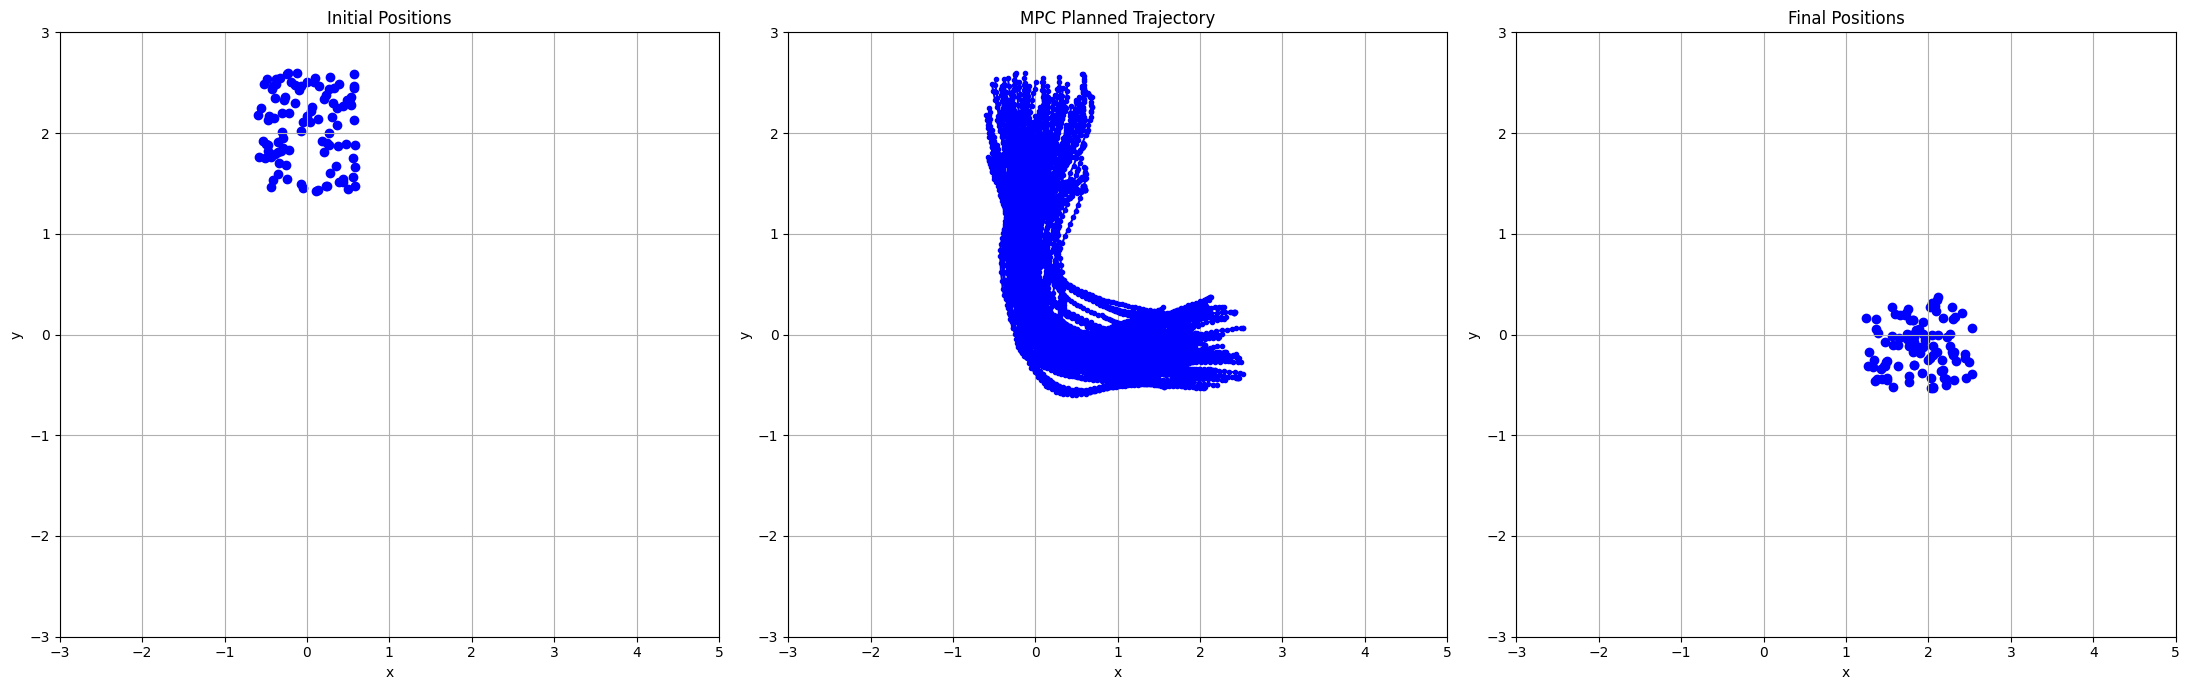

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj1_%s.npy" % (seed, i))
    initial_points1.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='blue')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj1_%s.npy" % (seed, i))
    final_points1.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='blue')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data1 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj1_%s.npy" % (seed, i))
    sampled_data1.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='blue', markersize=3)

plt.tight_layout()
plt.show()

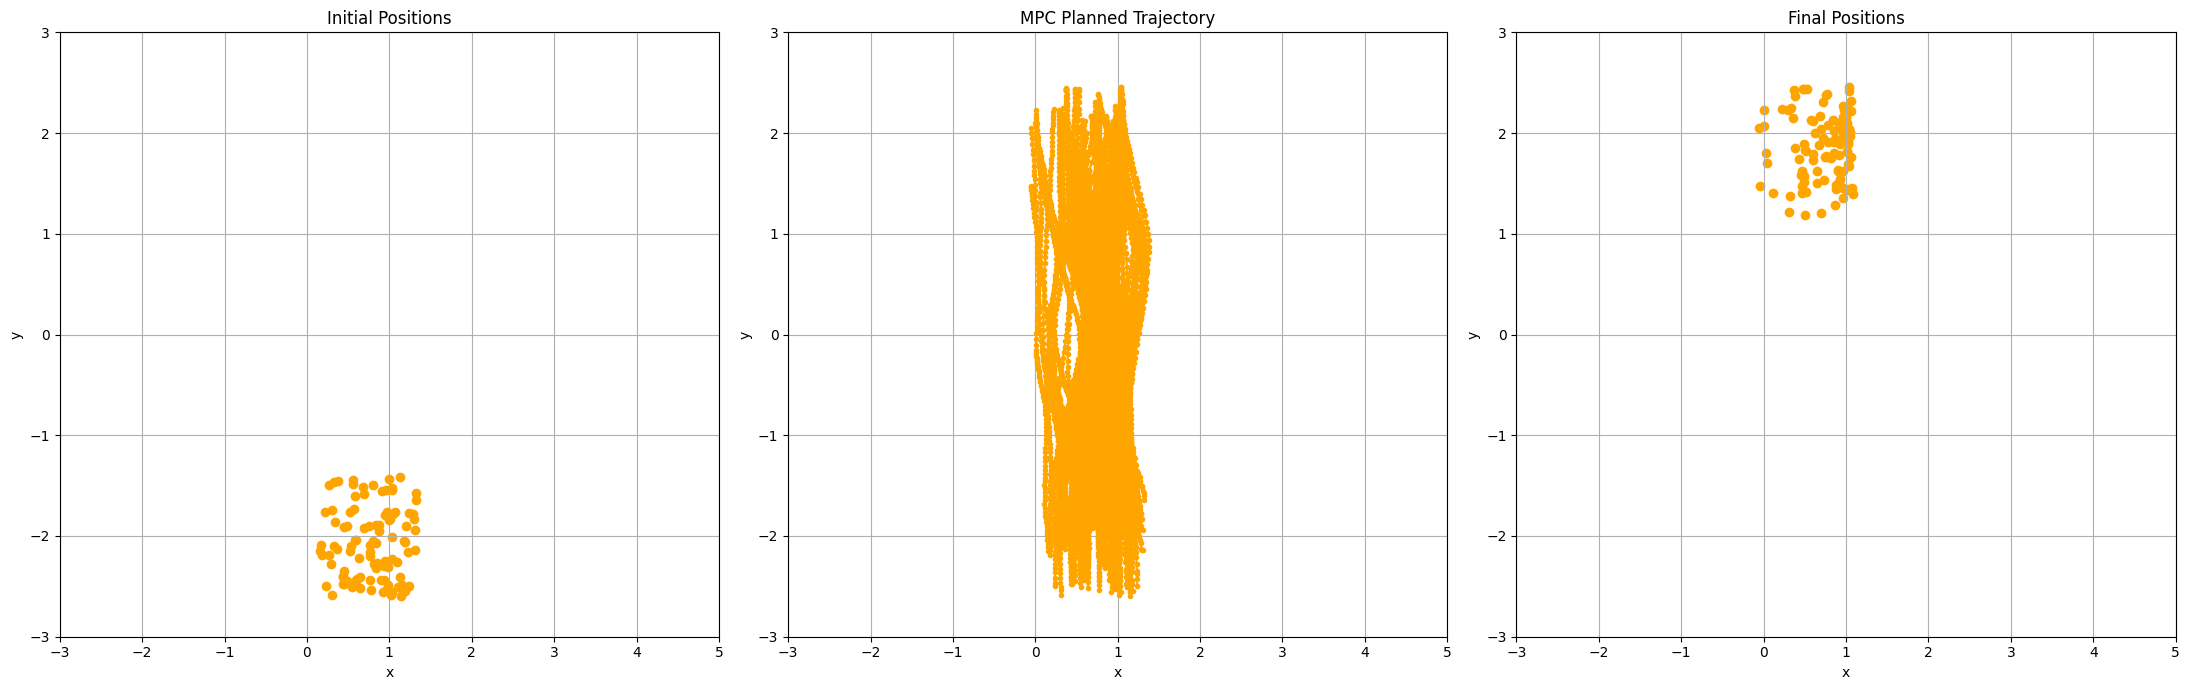

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj2_%s.npy" % (seed, i))
    initial_points2.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='orange')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj2_%s.npy" % (seed, i))
    final_points2.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='orange')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data2 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj2_%s.npy" % (seed, i))
    sampled_data2.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='orange', markersize=3)

plt.tight_layout()
plt.show()

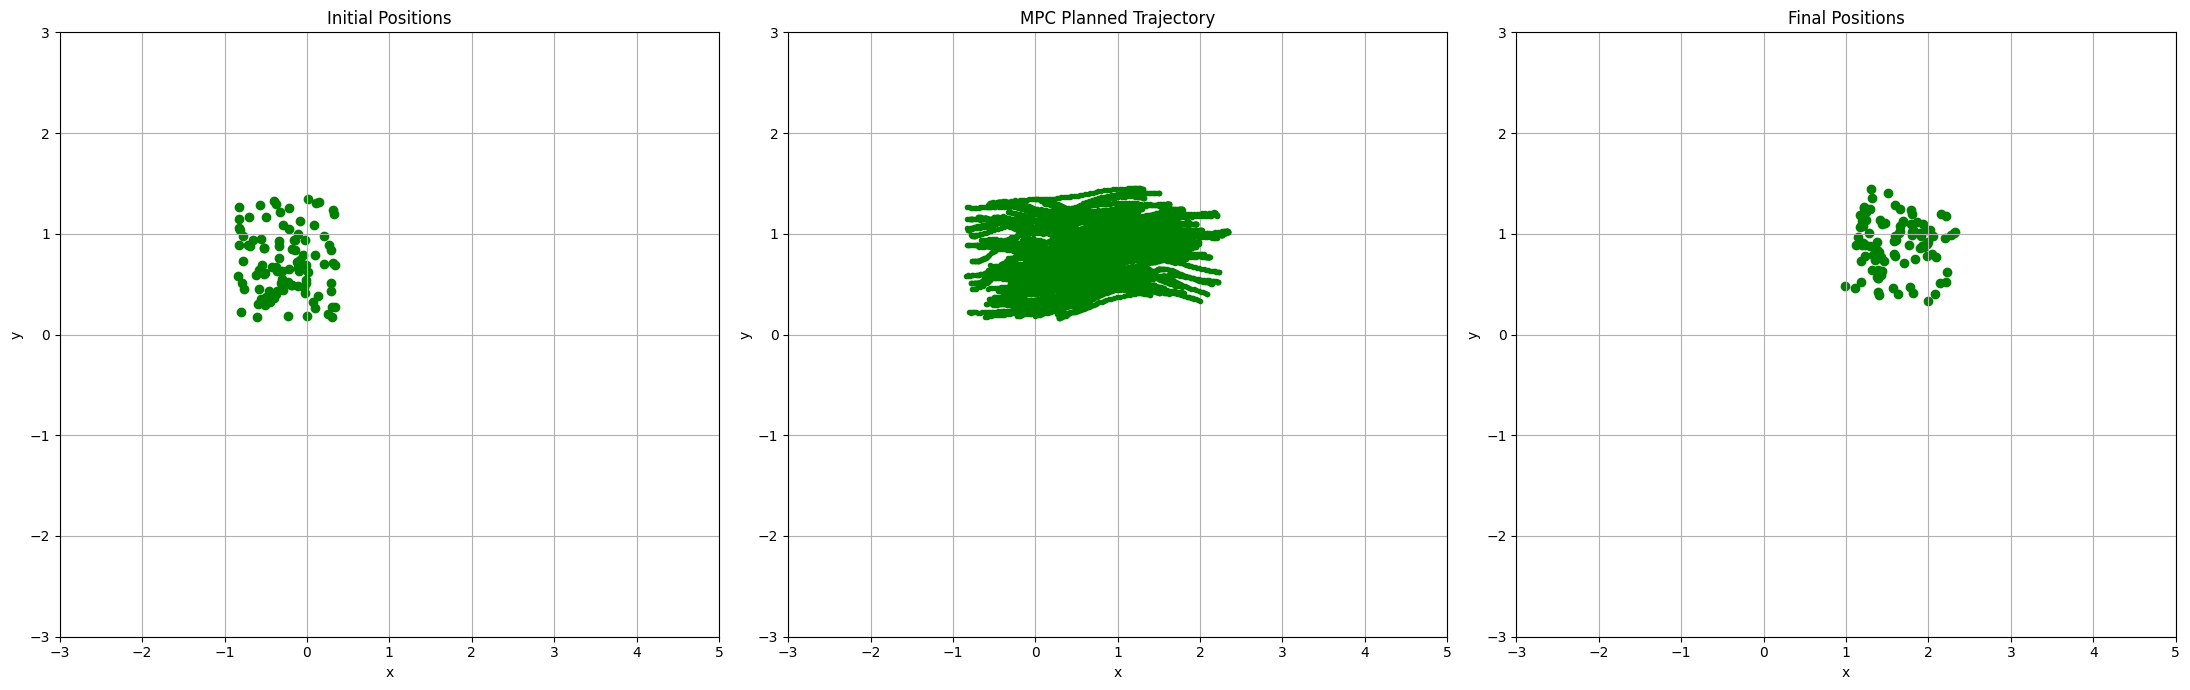

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj3_%s.npy" % (seed, i))
    initial_points3.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='green')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj3_%s.npy" % (seed, i))
    final_points3.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='green')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data3 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_seed%s/mpc_traj3_%s.npy" % (seed, i))
    sampled_data3.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='green', markersize=3)

plt.tight_layout()
plt.show()

In [86]:
count_collisions_multi([np.array(sampled_data1), np.array(sampled_data2), np.array(sampled_data3)], threshold=0.375, edge_ignore=0)

No collisions found (outside ignored edges).


0

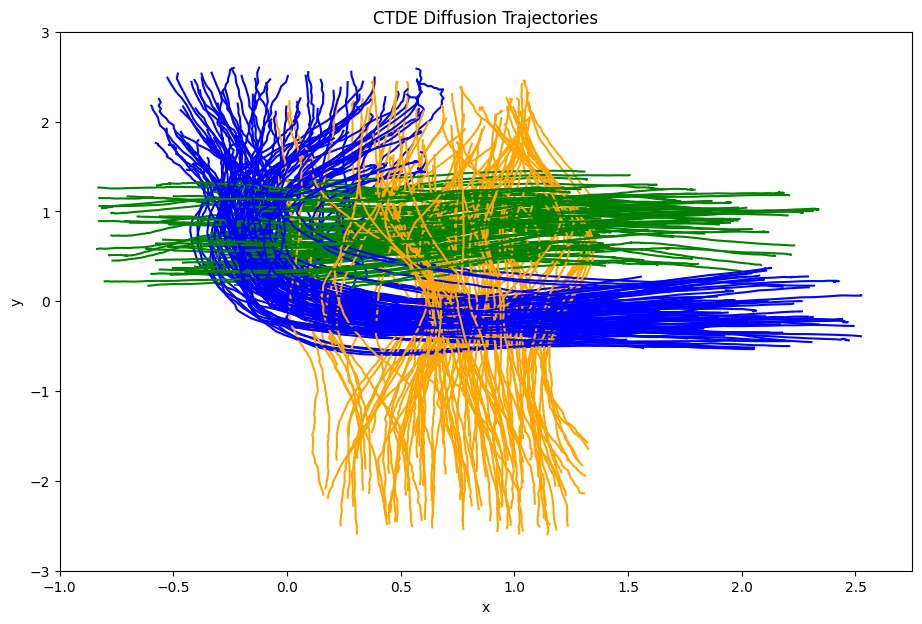

In [52]:
plt.figure(figsize=(11, 7))
plt.ylim(-3, 3)
plt.xlim(-1,2.75)
plt.xlabel("x")
plt.ylabel("y")
plt.title("CTDE Diffusion Trajectories")

for i in range(100):
    plt.plot(sampled_data1[i][:, 0], sampled_data1[i][:, 1], '-', color='blue')
    plt.plot(sampled_data2[i][:, 0], sampled_data2[i][:, 1], '-', color='orange')
    plt.plot(sampled_data3[i][:, 0], sampled_data3[i][:, 1], '-', color='green')

In [53]:
# plot_colliding_trios([np.array(sampled_data1), np.array(sampled_data2), np.array(sampled_data3)], threshold=0.5, max_plots=1)

In [54]:
# animate_colliding_trios([np.array(sampled_data1), np.array(sampled_data2), np.array(sampled_data3)], threshold=0.5, max_plots=5, interval=100)

In [55]:
# Vanilla CTDE Diffusion No Final Position

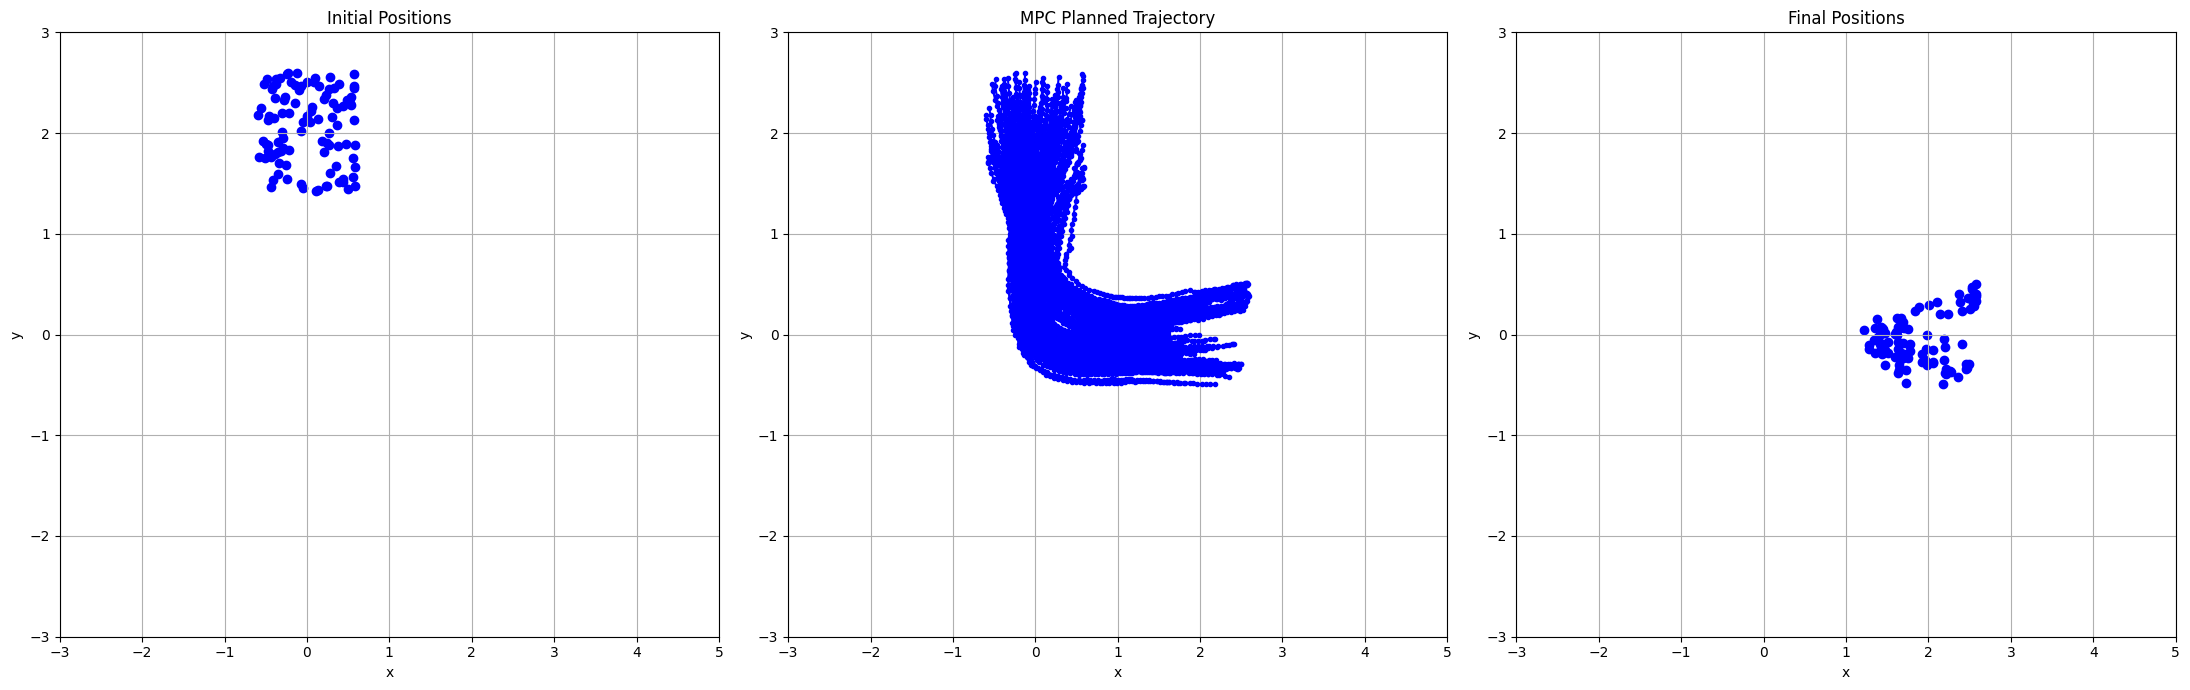

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj1_%s.npy" % (seed, i))
    initial_points1.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='blue')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj1_%s.npy" % (seed, i))
    final_points1.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='blue')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data1 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj1_%s.npy" % (seed, i))
    sampled_data1.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='blue', markersize=3)

plt.tight_layout()
plt.show()

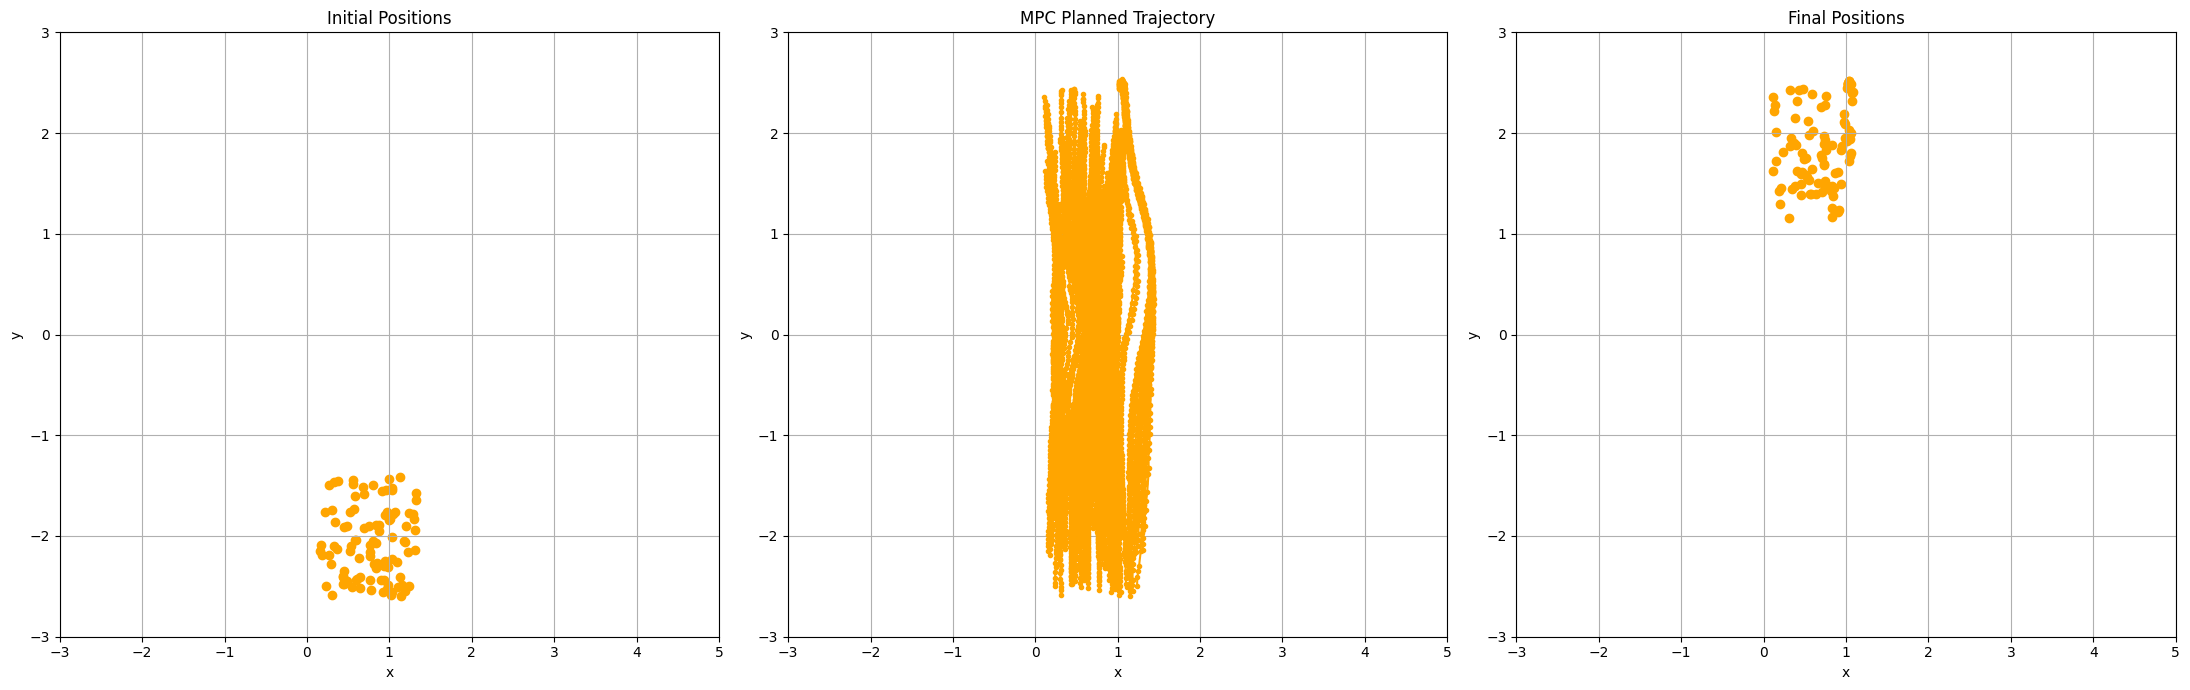

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj2_%s.npy" % (seed, i))
    initial_points2.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='orange')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj2_%s.npy" % (seed, i))
    final_points2.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='orange')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data2 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj2_%s.npy" % (seed, i))
    sampled_data2.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='orange', markersize=3)

plt.tight_layout()
plt.show()

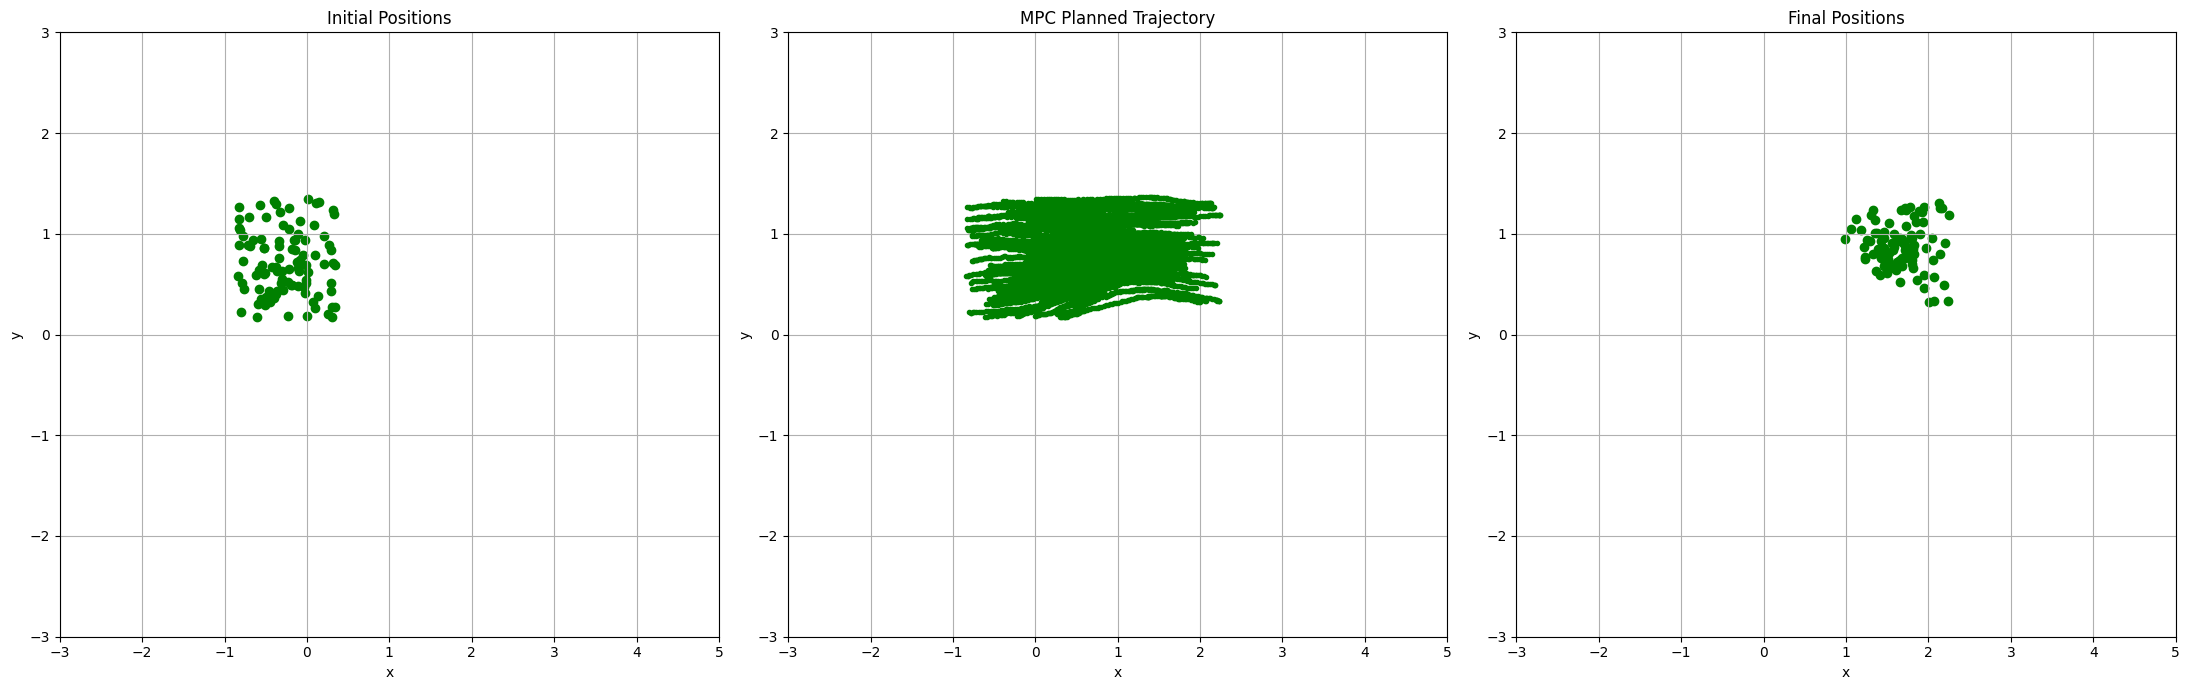

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj3_%s.npy" % (seed, i))
    initial_points3.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='green')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj3_%s.npy" % (seed, i))
    final_points3.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='green')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data3 = []
for i in range(100):
    data = np.load("sampled_trajs/vanillaCTDE_seed%s/mpc_traj3_%s.npy" % (seed, i))
    sampled_data3.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='green', markersize=3)

plt.tight_layout()
plt.show()

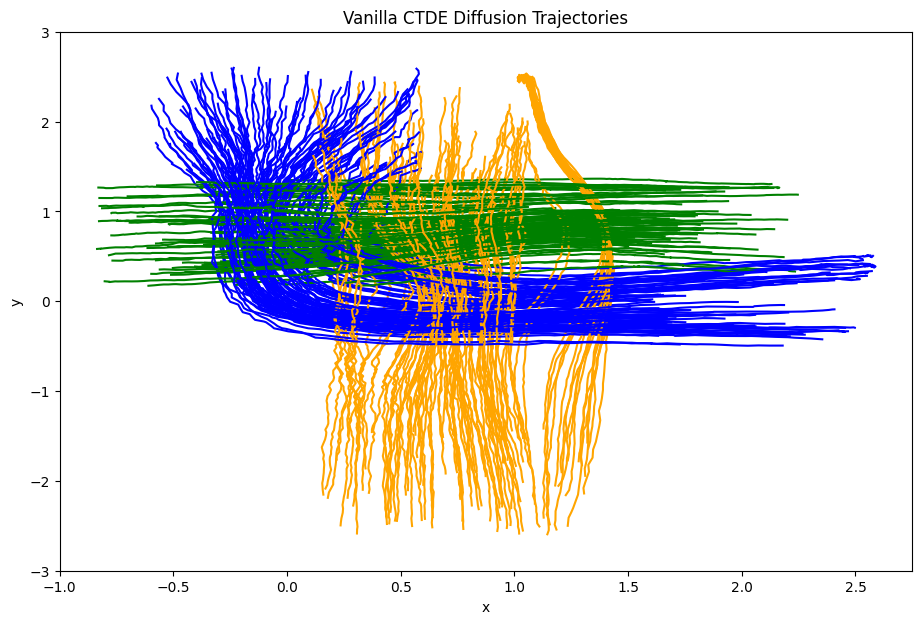

In [90]:
plt.figure(figsize=(11, 7))
plt.ylim(-3, 3)
plt.xlim(-1,2.75)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Vanilla CTDE Diffusion Trajectories")

for i in range(100):
    plt.plot(sampled_data1[i][:, 0], sampled_data1[i][:, 1], '-', color='blue')
    plt.plot(sampled_data2[i][:, 0], sampled_data2[i][:, 1], '-', color='orange')
    plt.plot(sampled_data3[i][:, 0], sampled_data3[i][:, 1], '-', color='green')

In [94]:
count_collisions_multi([np.array(sampled_data1), np.array(sampled_data2), np.array(sampled_data3)], threshold=0.375, edge_ignore=0)

Colliding trajectory indices (excluding first/last 0): [0, 2, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 40, 41, 42, 44, 45, 46, 47, 48, 50, 56, 57, 59, 60, 62, 65, 67, 70, 72, 75, 76, 77, 78, 81, 85, 86, 87, 89, 91, 93, 94, 95, 96, 97, 98]


61

In [61]:
# BC Conditioned on Own Current Position and Other Agents' Current Position

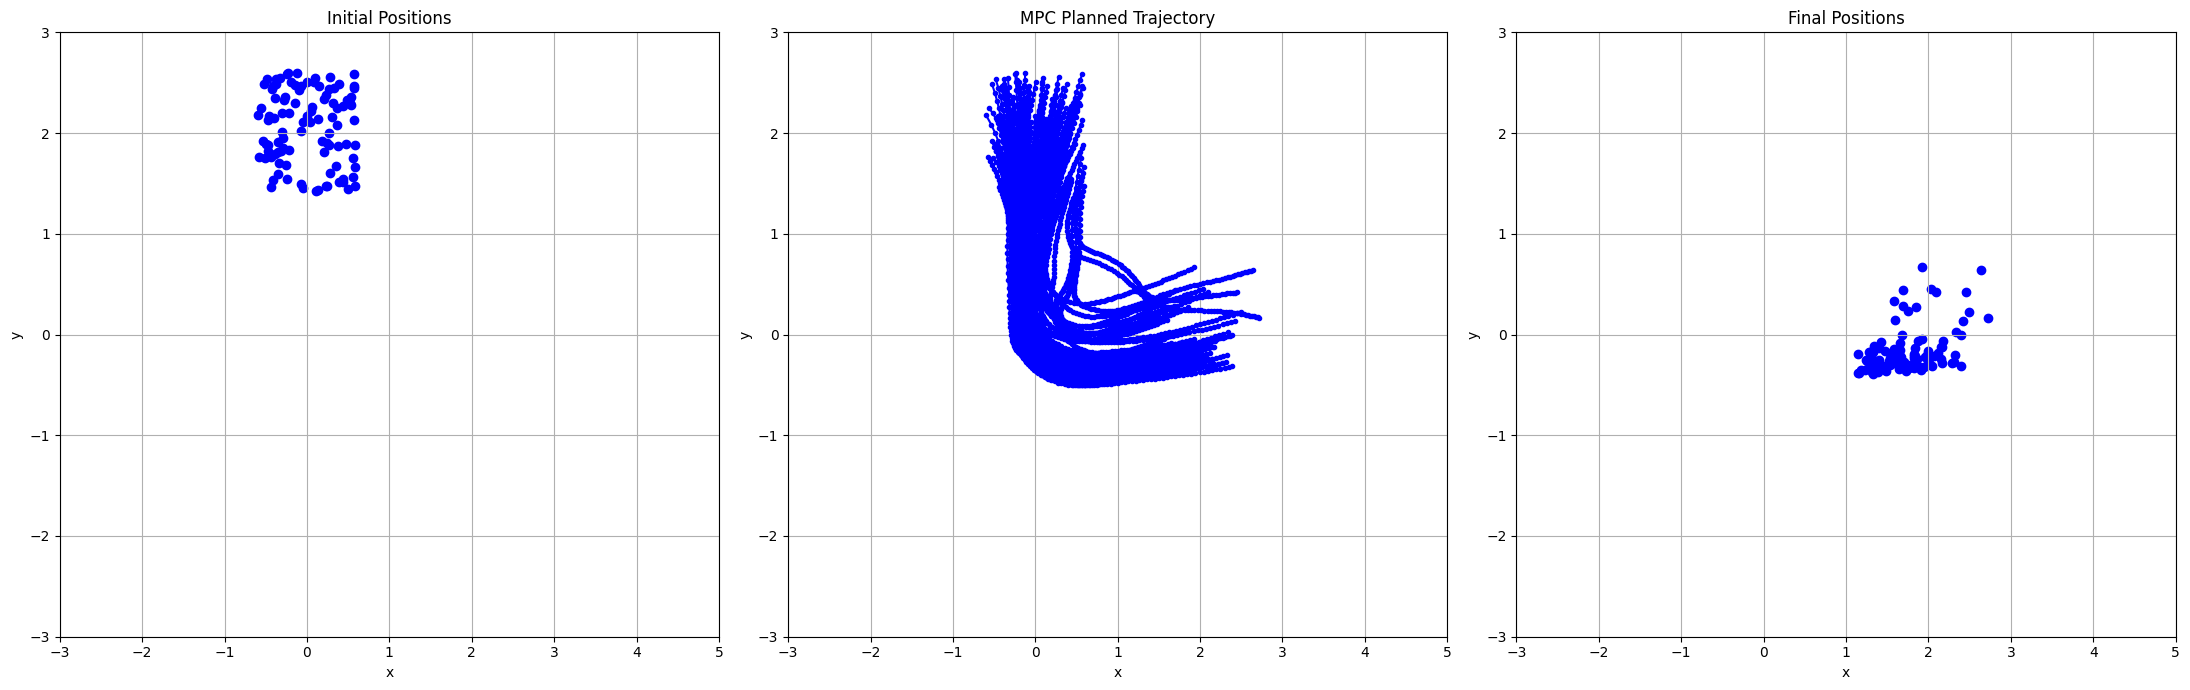

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj1_%s.npy" % (seed, i))
    initial_points1.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='blue')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj1_%s.npy" % (seed, i))
    final_points1.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='blue')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data1 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj1_%s.npy" % (seed, i))
    sampled_data1.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='blue', markersize=3)

plt.tight_layout()
plt.show()

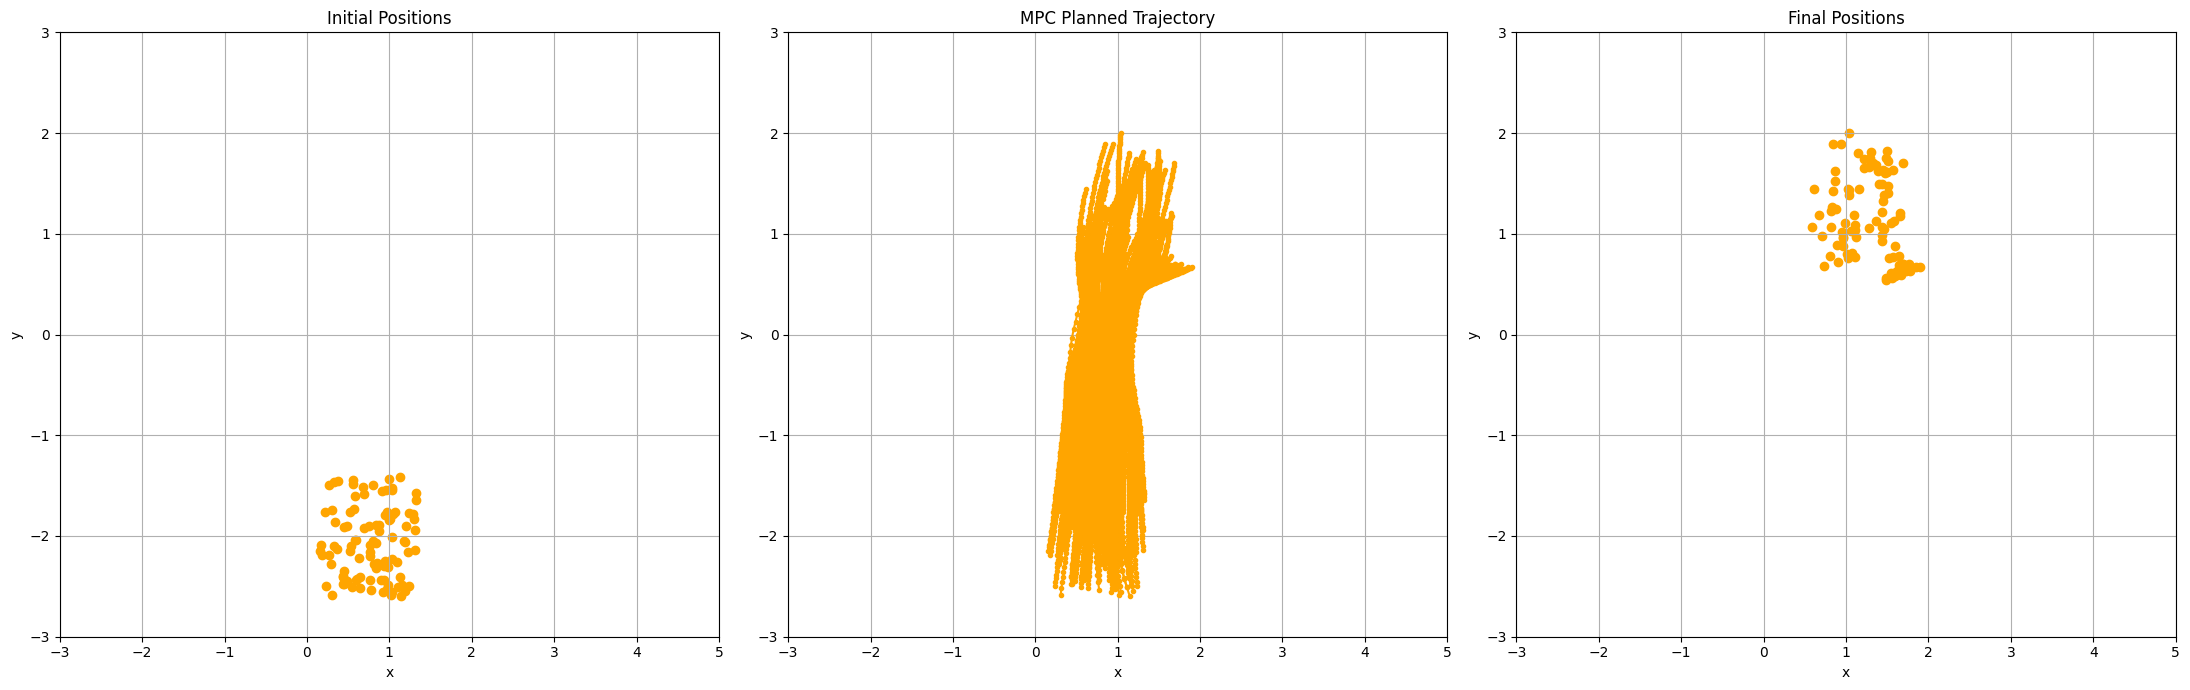

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj2_%s.npy" % (seed, i))
    initial_points2.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='orange')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj2_%s.npy" % (seed, i))
    final_points2.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='orange')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data2 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj2_%s.npy" % (seed, i))
    sampled_data2.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='orange', markersize=3)

plt.tight_layout()
plt.show()

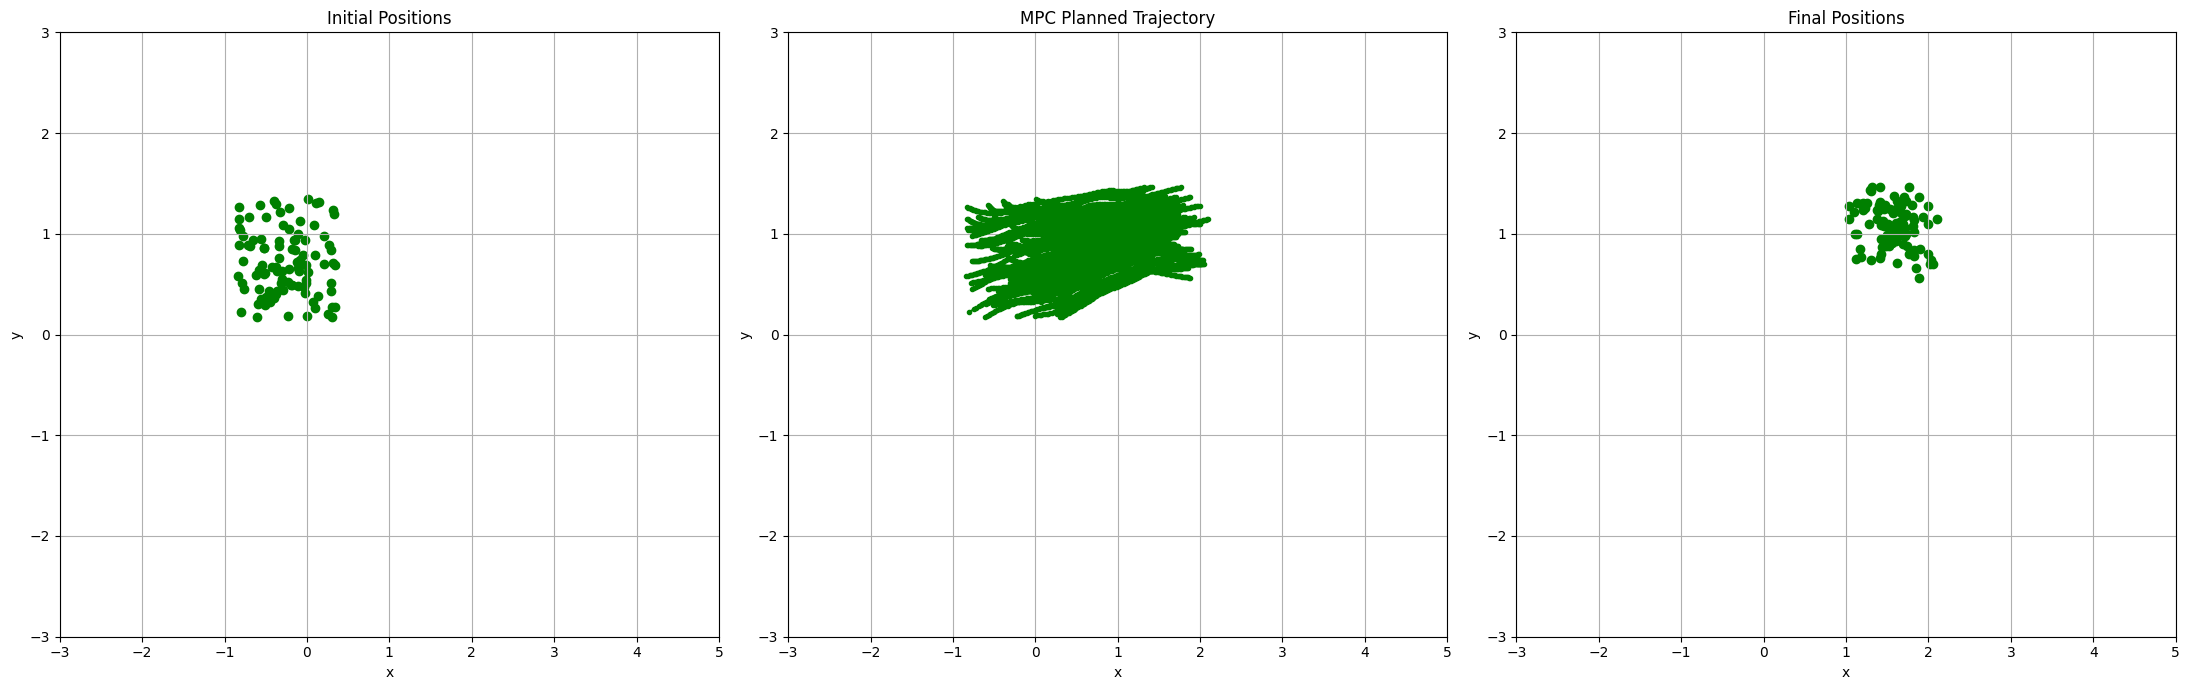

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj3_%s.npy" % (seed, i))
    initial_points3.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='green')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj3_%s.npy" % (seed, i))
    final_points3.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='green')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data3 = []
for i in range(100):
    data = np.load("sampled_trajs/bc_seed%s/mpc_traj3_%s.npy" % (seed, i))
    sampled_data3.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='green', markersize=3)

plt.tight_layout()
plt.show()

In [101]:
count_collisions_multi([np.array(sampled_data1), np.array(sampled_data2), np.array(sampled_data3)], threshold=0.375, edge_ignore=0)

Colliding trajectory indices (excluding first/last 0): [0, 3, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 22, 23, 24, 26, 27, 30, 31, 32, 33, 36, 37, 39, 40, 41, 42, 45, 46, 47, 49, 50, 53, 54, 55, 58, 59, 60, 62, 63, 67, 70, 71, 76, 83, 84, 85, 86, 87, 91, 93, 94, 95, 98, 99]


55

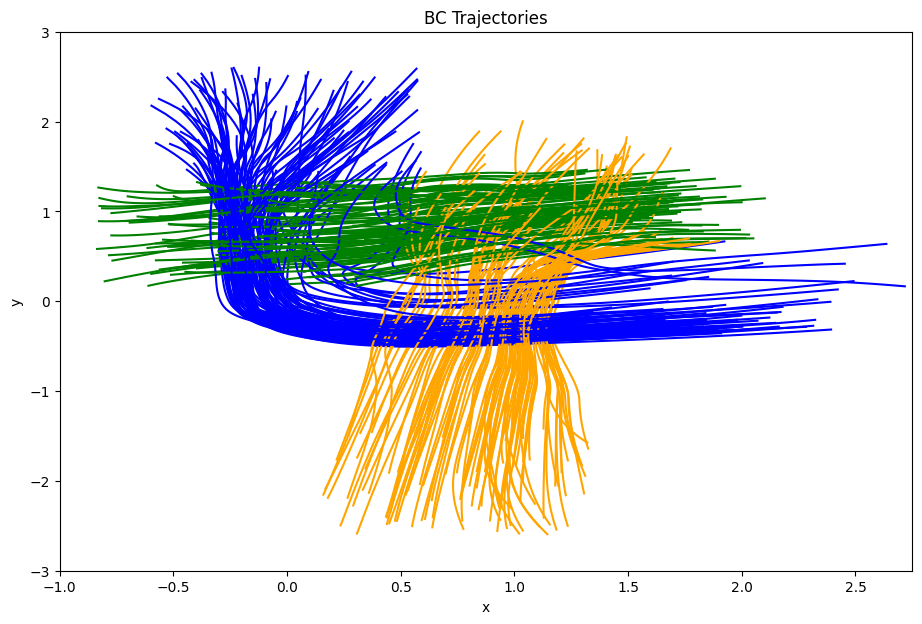

In [66]:
plt.figure(figsize=(11, 7))
plt.ylim(-3, 3)
plt.xlim(-1,2.75)
plt.xlabel("x")
plt.ylabel("y")
plt.title("BC Trajectories")

for i in range(100):
    plt.plot(sampled_data1[i][:, 0], sampled_data1[i][:, 1], '-', color='blue')
    plt.plot(sampled_data2[i][:, 0], sampled_data2[i][:, 1], '-', color='orange')
    plt.plot(sampled_data3[i][:, 0], sampled_data3[i][:, 1], '-', color='green')

In [67]:
# MAGAIL Conditioned on Own Current Position and Other Agents' Current Position Vary Initial Position

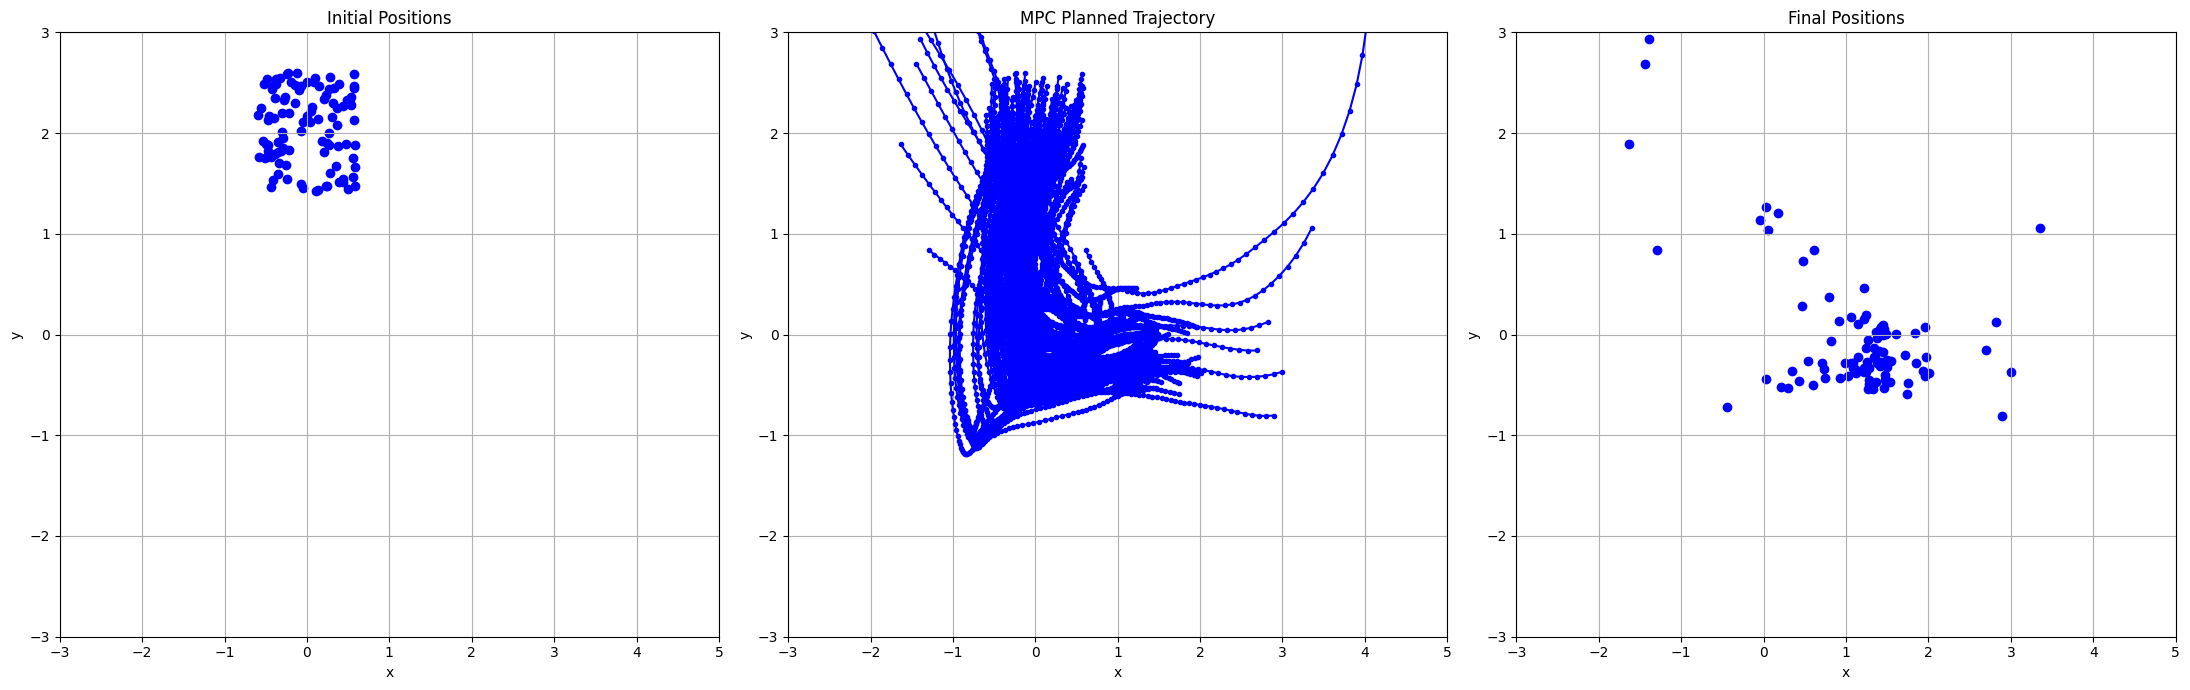

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj1_%s.npy" % (seed, i))
    initial_points1.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='blue')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj1_%s.npy" % (seed, i))
    final_points1.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='blue')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data1 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj1_%s.npy" % (seed, i))
    sampled_data1.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='blue', markersize=3)

plt.tight_layout()
plt.show()

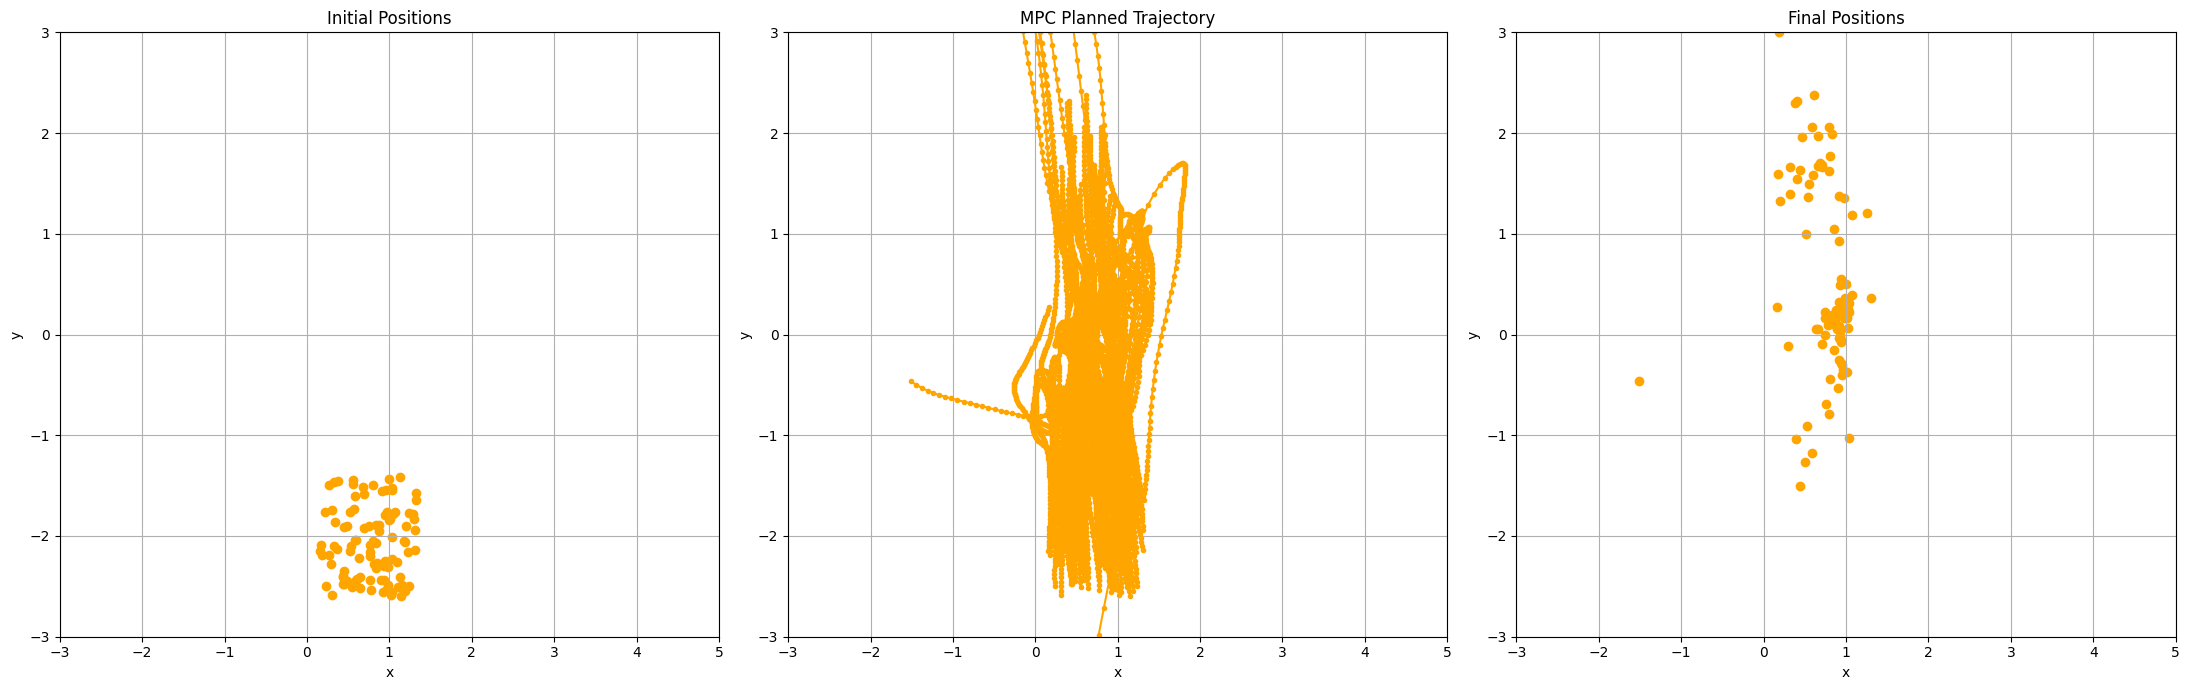

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj2_%s.npy" % (seed, i))
    initial_points2.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='orange')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj2_%s.npy" % (seed, i))
    final_points2.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='orange')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data2 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj2_%s.npy" % (seed, i))
    sampled_data2.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='orange', markersize=3)

plt.tight_layout()
plt.show()

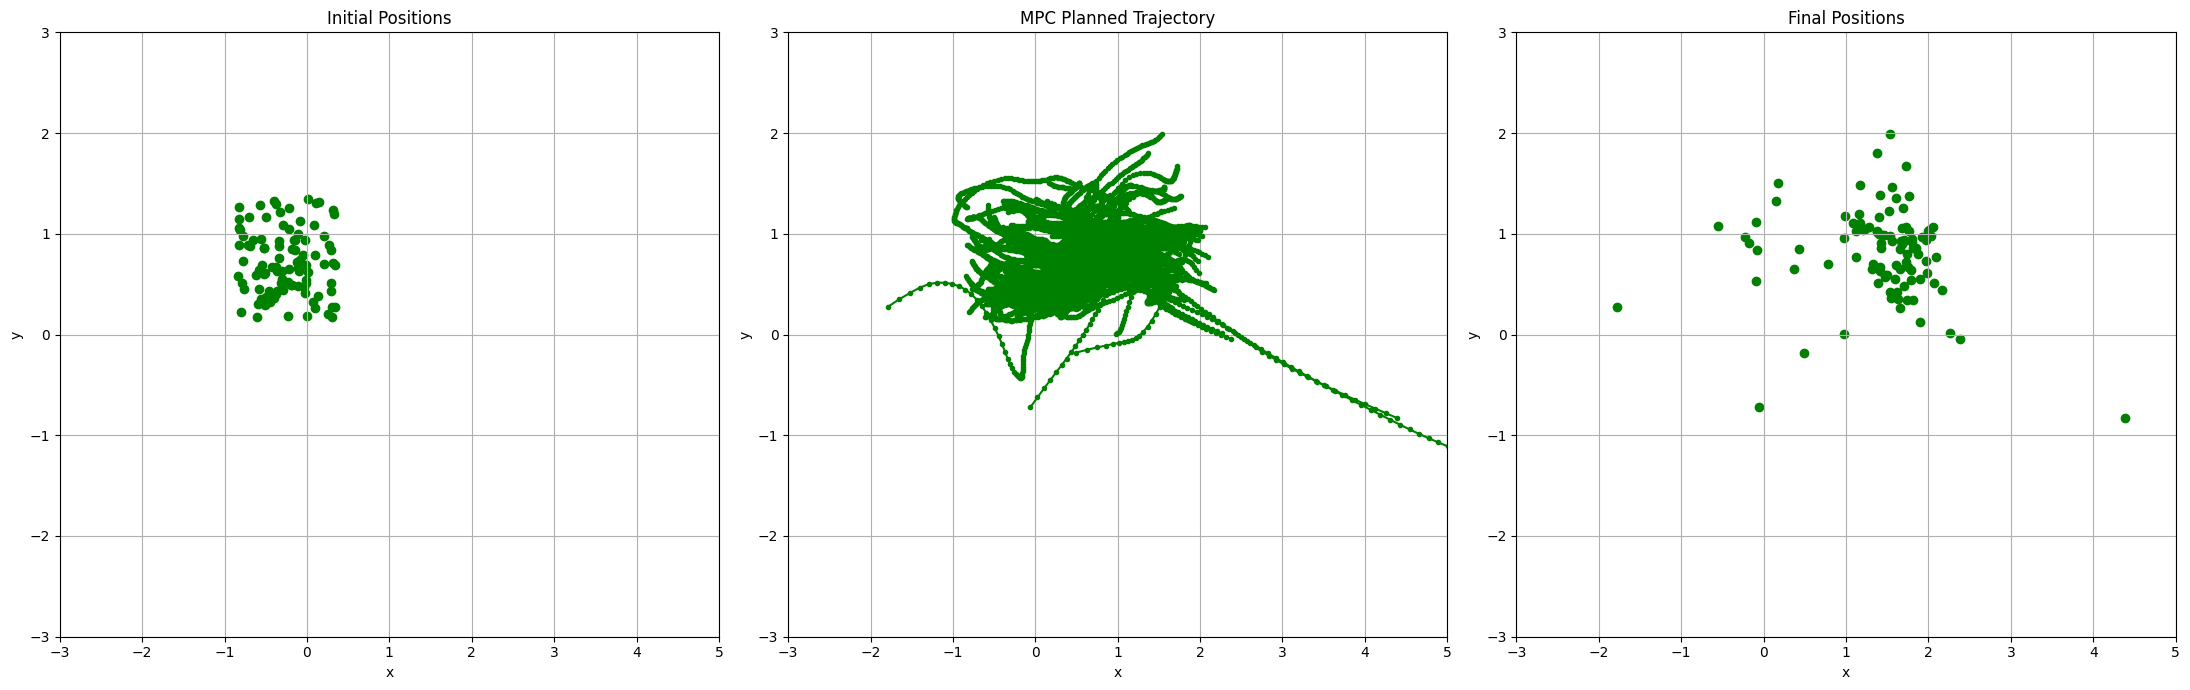

In [104]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj3_%s.npy" % (seed, i))
    initial_points3.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='green')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj3_%s.npy" % (seed, i))
    final_points3.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='green')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data3 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/vary_init/mpc_traj3_%s.npy" % (seed, i))
    sampled_data3.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='green', markersize=3)

plt.tight_layout()
plt.show()

In [108]:
count_collisions_multi([np.array(sampled_data1), np.array(sampled_data2), np.array(sampled_data3)], threshold=0.375, edge_ignore=0)

Colliding trajectory indices (excluding first/last 0): [6, 7, 13, 17, 21, 22, 27, 30, 34, 36, 40, 41, 42, 48, 59, 62, 66, 67, 71, 74, 75, 76, 77, 78, 86, 88, 93, 95, 96, 97, 98, 99]


32

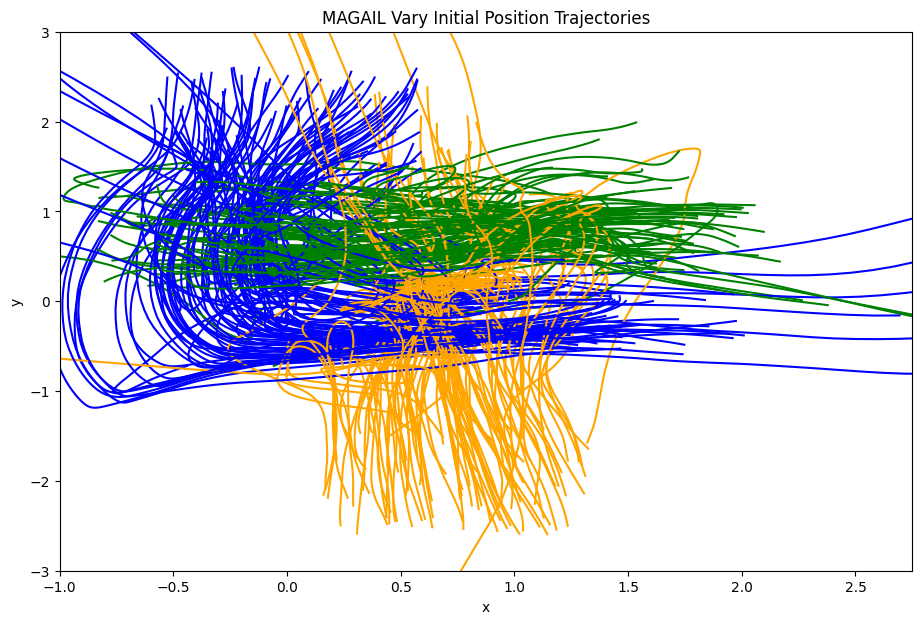

In [72]:
plt.figure(figsize=(11, 7))
plt.ylim(-3, 3)
plt.xlim(-1,2.75)
plt.xlabel("x")
plt.ylabel("y")
plt.title("MAGAIL Vary Initial Position Trajectories")

for i in range(100):
    plt.plot(sampled_data1[i][:, 0], sampled_data1[i][:, 1], '-', color='blue')
    plt.plot(sampled_data2[i][:, 0], sampled_data2[i][:, 1], '-', color='orange')
    plt.plot(sampled_data3[i][:, 0], sampled_data3[i][:, 1], '-', color='green')

In [73]:
# MAGAIL Conditioned on Own Current Position and Other Agents' Current Position Static Initial Position

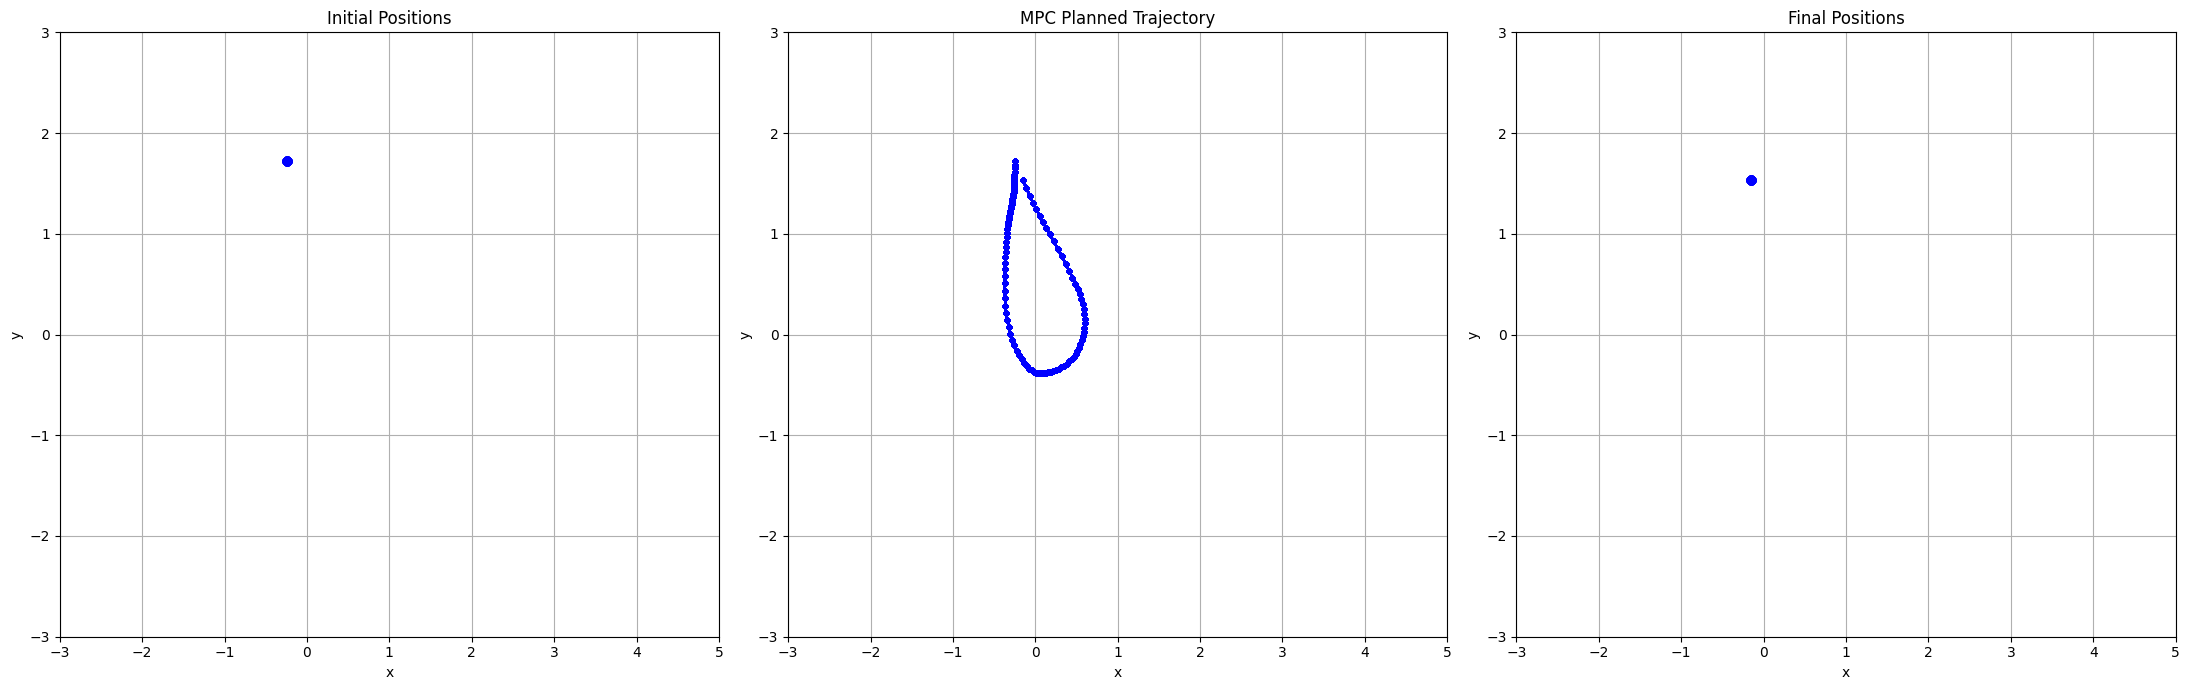

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj1_%s.npy" % (seed, i))
    initial_points1.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='blue')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj1_%s.npy" % (seed, i))
    final_points1.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='blue')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data1 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj1_%s.npy" % (seed, i))
    sampled_data1.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='blue', markersize=3)

plt.tight_layout()
plt.show()

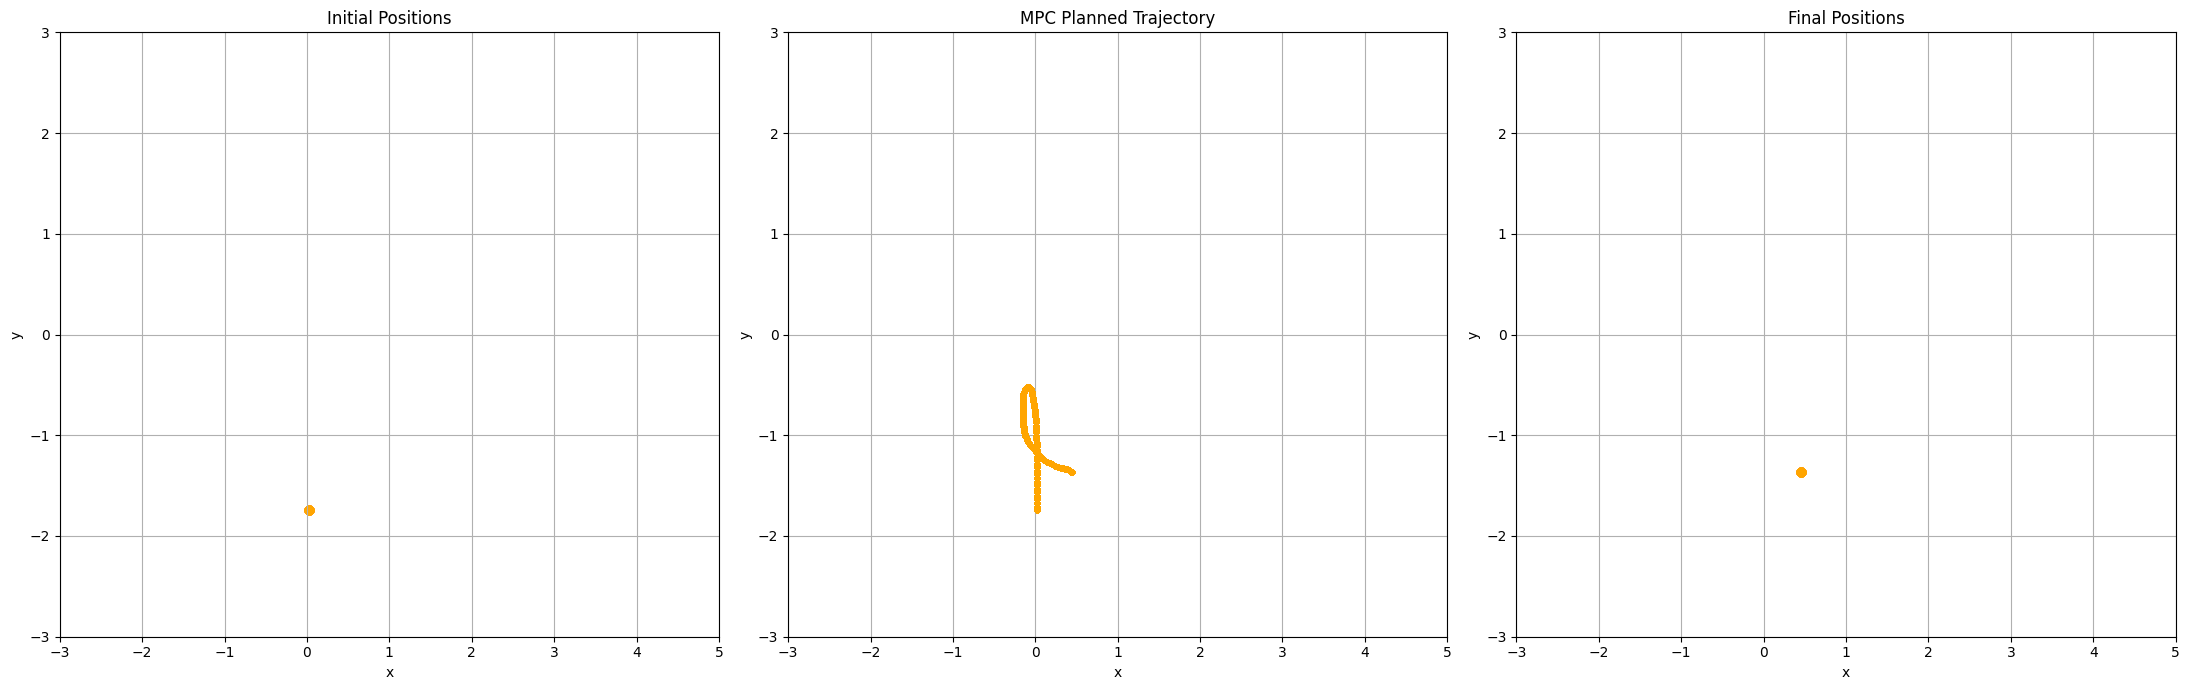

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj2_%s.npy" % (seed, i))
    initial_points2.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='orange')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj2_%s.npy" % (seed, i))
    final_points2.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='orange')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data2 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj2_%s.npy" % (seed, i))
    sampled_data2.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='orange', markersize=3)

plt.tight_layout()
plt.show()

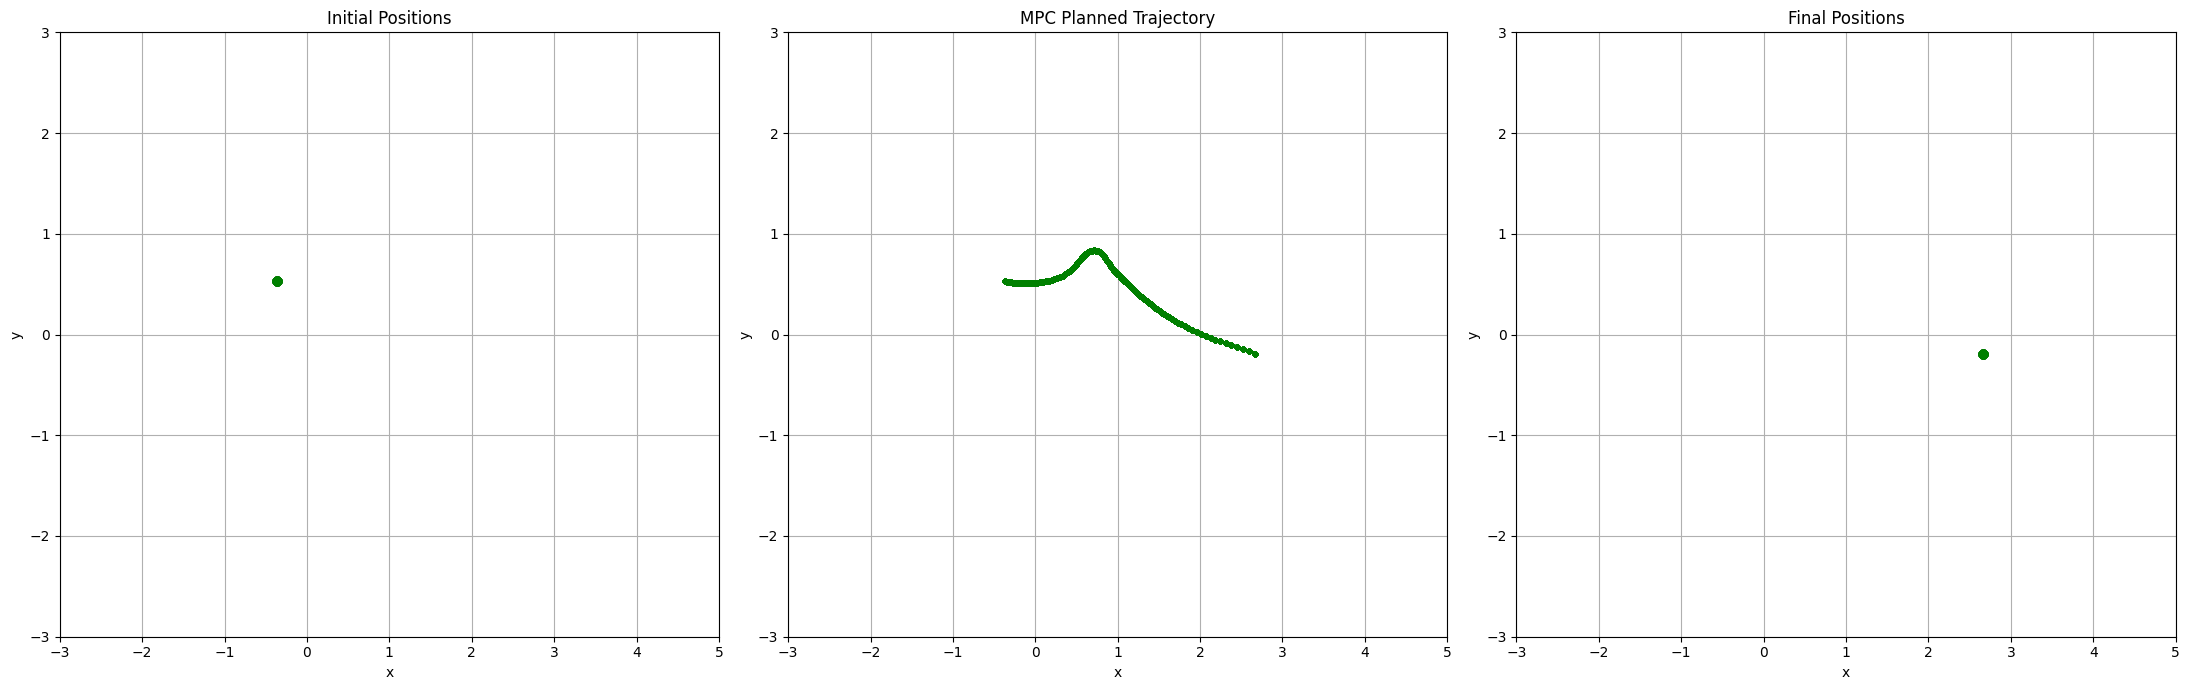

In [113]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj3_%s.npy" % (seed, i))
    initial_points3.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='green')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj3_%s.npy" % (seed, i))
    final_points3.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='green')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data3 = []
for i in range(100):
    data = np.load("sampled_trajs/magail_seed%s/static_init/mpc_traj3_%s.npy" % (seed, i))
    sampled_data3.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='green', markersize=3)

plt.tight_layout()
plt.show()

In [114]:
count_collisions_multi([np.array(sampled_data1), np.array(sampled_data2), np.array(sampled_data3)], threshold=0.375, edge_ignore=0)

Colliding trajectory indices (excluding first/last 0): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


100

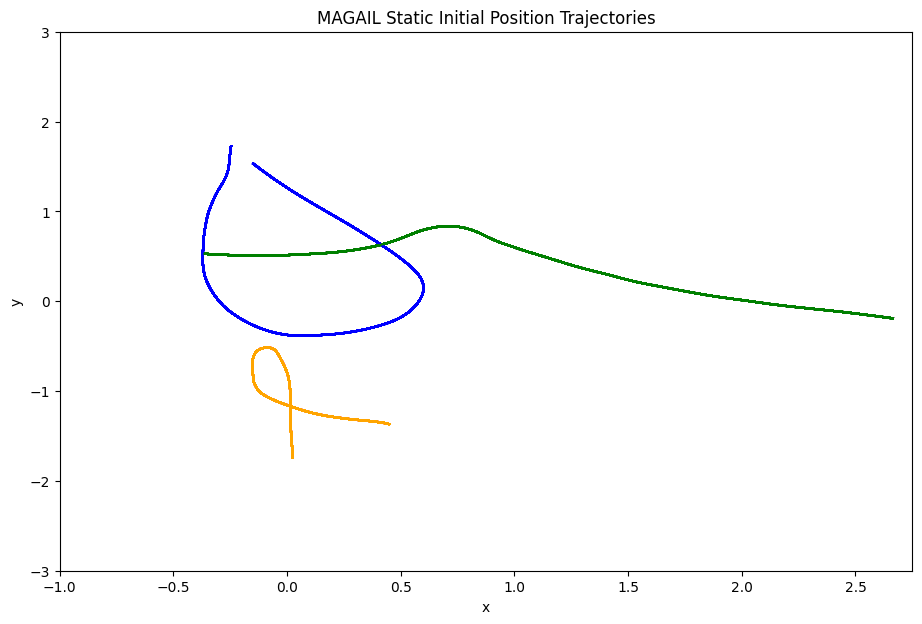

In [78]:
plt.figure(figsize=(11, 7))
plt.ylim(-3, 3)
plt.xlim(-1,2.75)
plt.xlabel("x")
plt.ylabel("y")
plt.title("MAGAIL Static Initial Position Trajectories")

for i in range(100):
    plt.plot(sampled_data1[i][:, 0], sampled_data1[i][:, 1], '-', color='blue')
    plt.plot(sampled_data2[i][:, 0], sampled_data2[i][:, 1], '-', color='orange')
    plt.plot(sampled_data3[i][:, 0], sampled_data3[i][:, 1], '-', color='green')

In [1]:
# CTDE Diffusion Extra Info

In [9]:
seed = 0

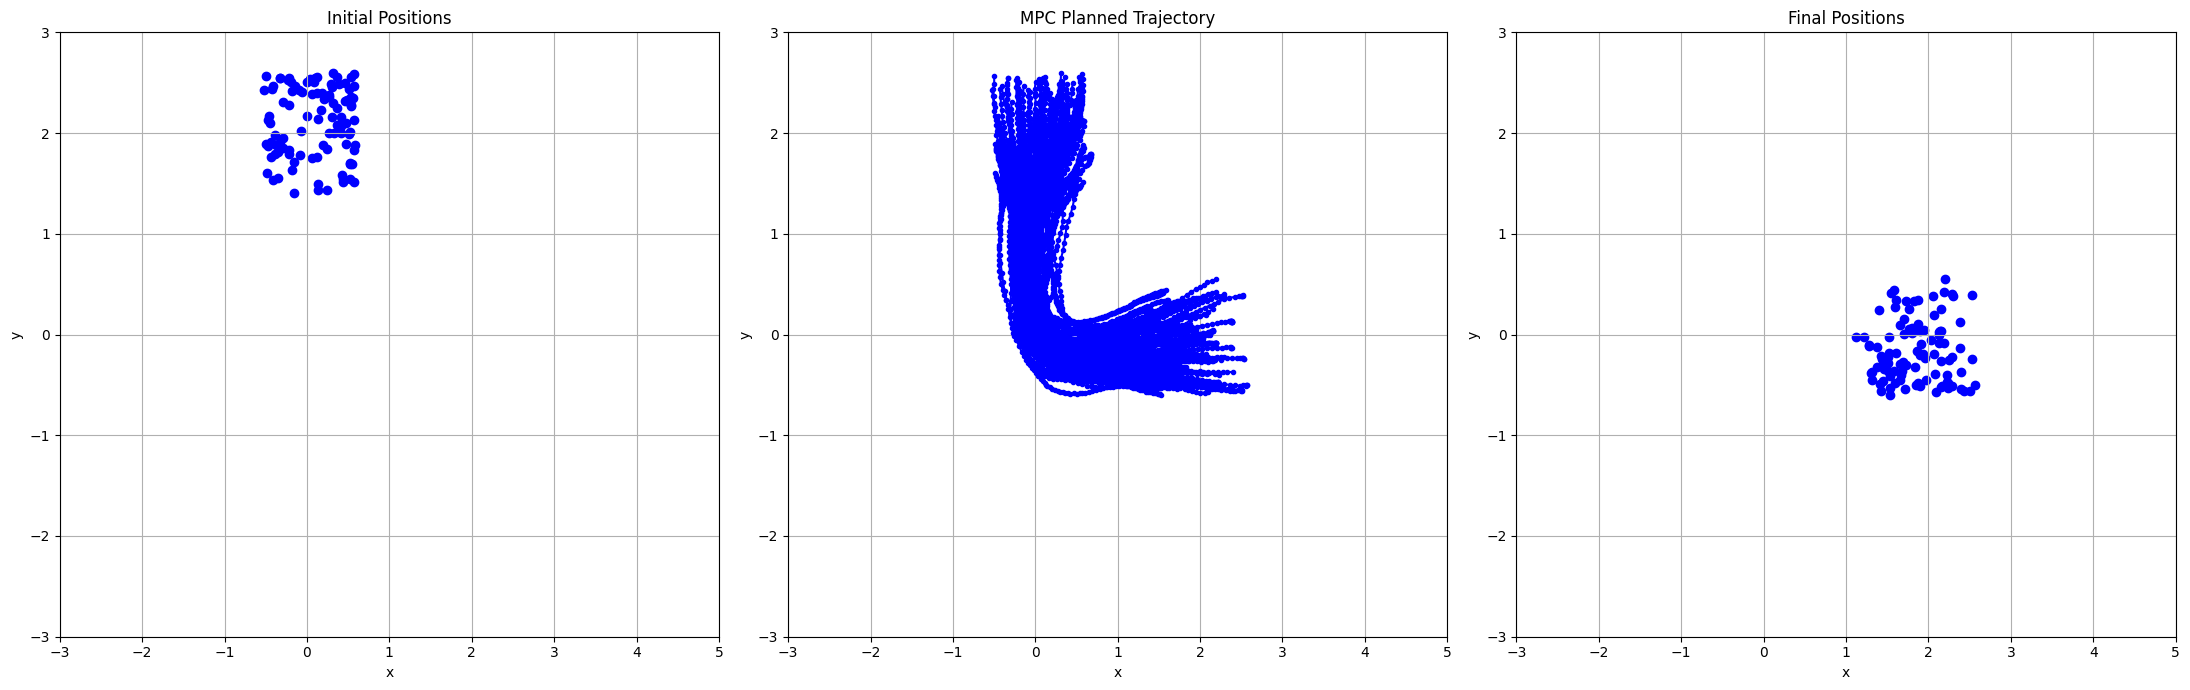

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj1_%s.npy" % (seed, i))
    initial_points1.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='blue')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points1 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj1_%s.npy" % (seed, i))
    final_points1.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='blue')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data1 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj1_%s.npy" % (seed, i))
    sampled_data1.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='blue', markersize=3)

plt.tight_layout()
plt.show()

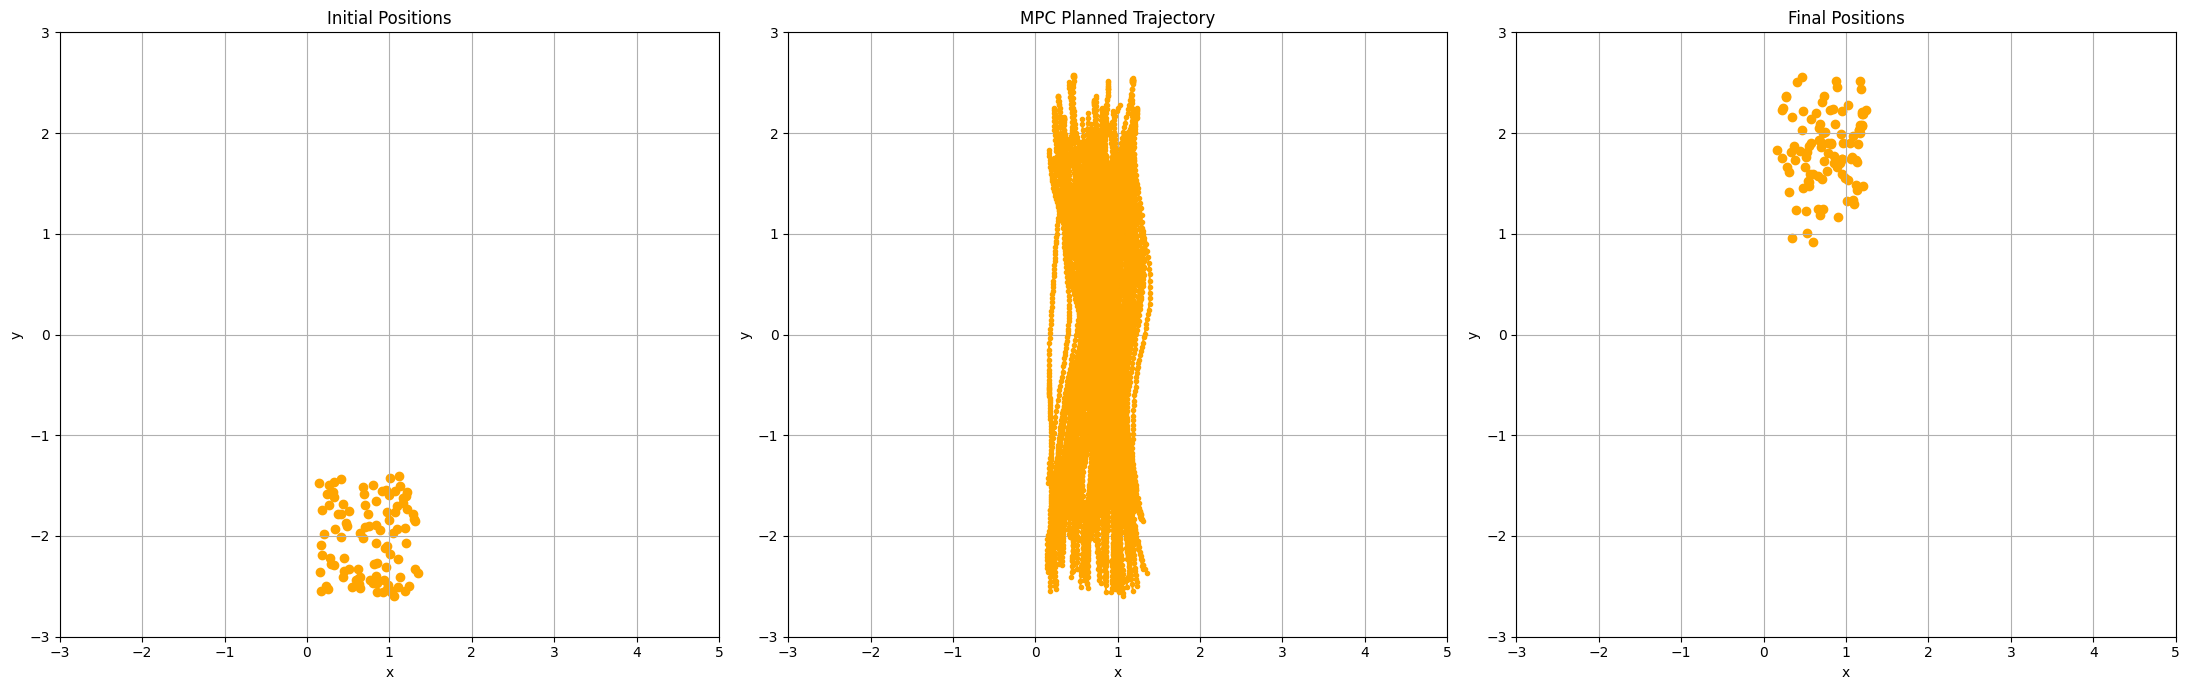

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj2_%s.npy" % (seed, i))
    initial_points2.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='orange')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points2 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj2_%s.npy" % (seed, i))
    final_points2.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='orange')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data2 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj2_%s.npy" % (seed, i))
    sampled_data2.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='orange', markersize=3)

plt.tight_layout()
plt.show()

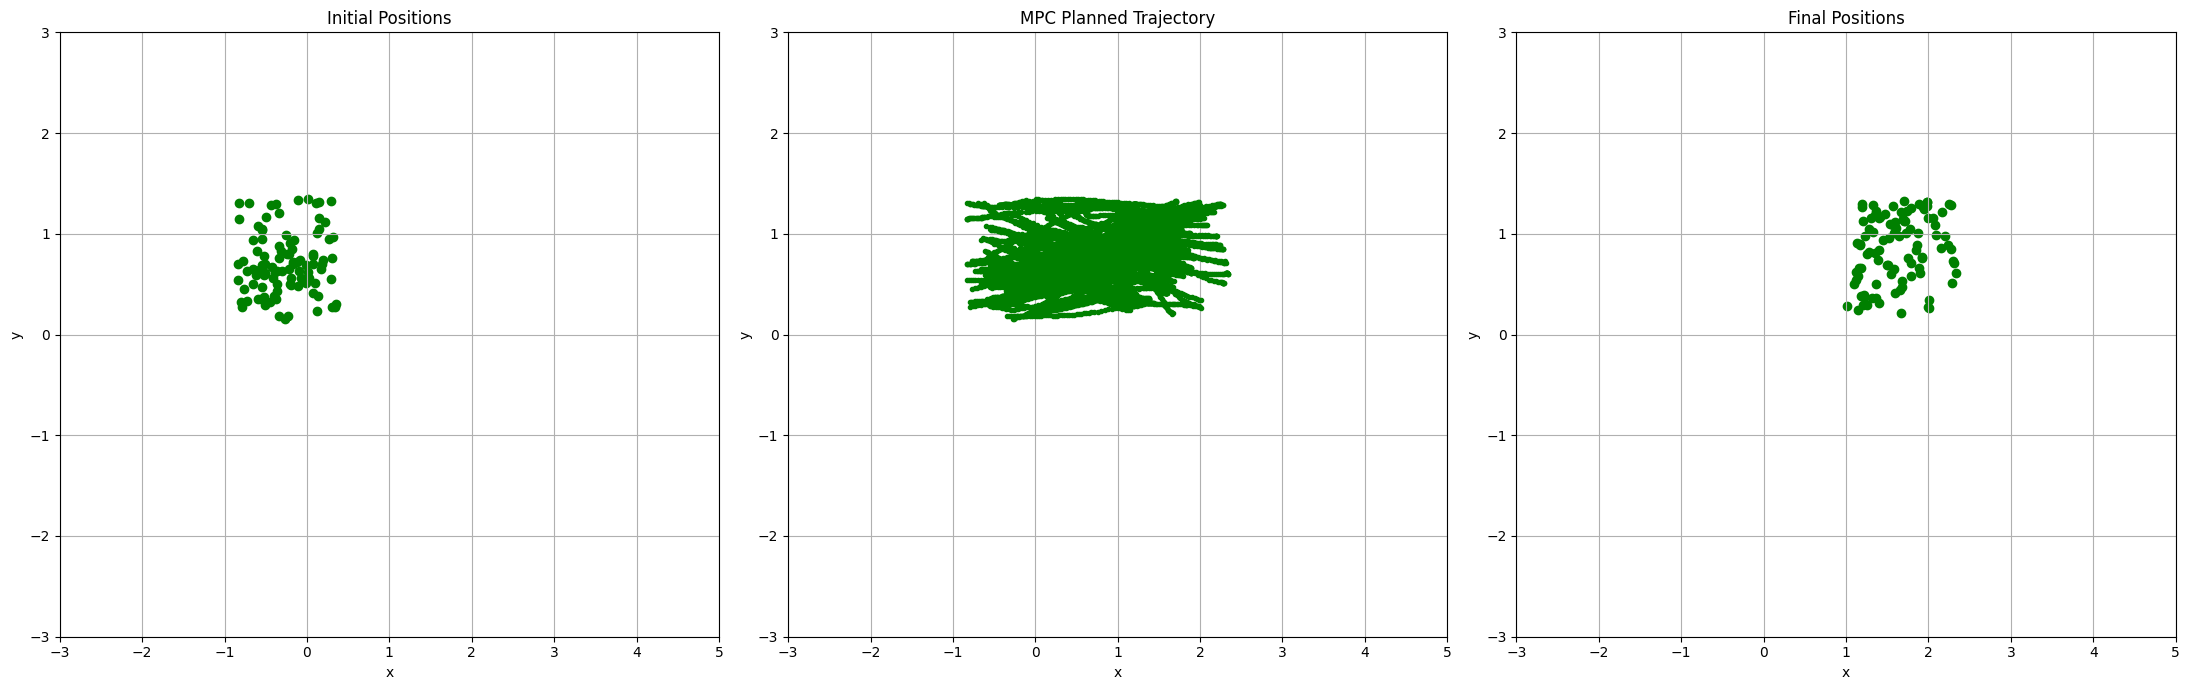

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

ax1.set_xlim(-3, 5)
ax1.set_ylim(-3, 3)
ax1.grid(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Initial Positions")
initial_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj3_%s.npy" % (seed, i))
    initial_points3.append(data)
    ax1.scatter(data[0, 0], data[0, 1], color='green')


ax3.set_xlim(-3, 5)
ax3.set_ylim(-3, 3)
ax3.grid(True)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Final Positions")
final_points3 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj3_%s.npy" % (seed, i))
    final_points3.append(data)
    ax3.scatter(data[-1, 0], data[-1, 1], color='green')


ax2.set_xlim(-3, 5)
ax2.set_ylim(-3, 3)
ax2.grid(True)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("MPC Planned Trajectory")
sampled_data3 = []
for i in range(100):
    data = np.load("sampled_trajs/ours_extrainfo_seed%s/mpc_traj3_%s.npy" % (seed, i))
    sampled_data3.append(data)
    ax2.plot(data[:, 0], data[:, 1], 'o-', color='green', markersize=3)

plt.tight_layout()
plt.show()

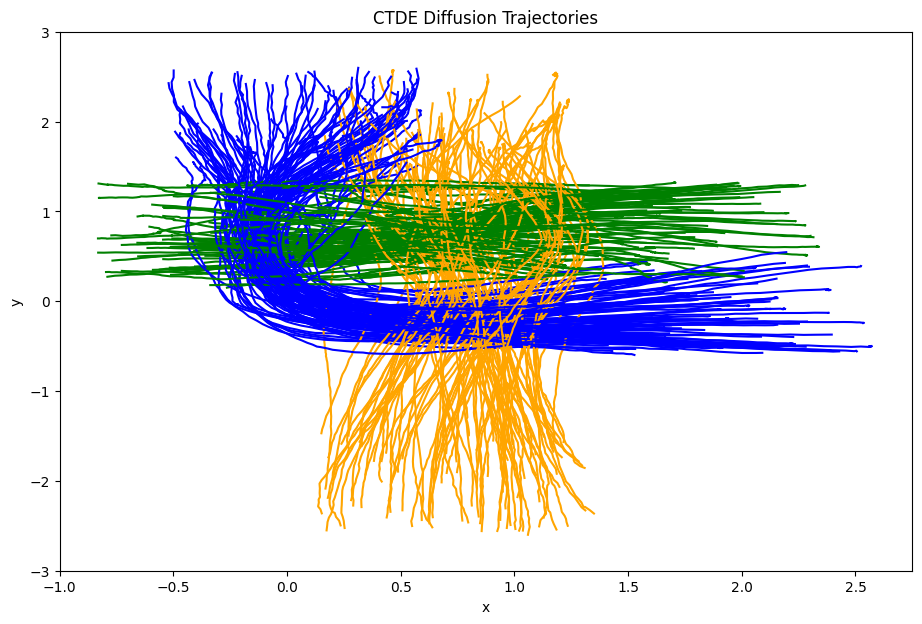

In [13]:
plt.figure(figsize=(11, 7))
plt.ylim(-3, 3)
plt.xlim(-1,2.75)
plt.xlabel("x")
plt.ylabel("y")
plt.title("CTDE Diffusion Trajectories")

for i in range(100):
    plt.plot(sampled_data1[i][:, 0], sampled_data1[i][:, 1], '-', color='blue')
    plt.plot(sampled_data2[i][:, 0], sampled_data2[i][:, 1], '-', color='orange')
    plt.plot(sampled_data3[i][:, 0], sampled_data3[i][:, 1], '-', color='green')

In [ ]:
count_collisions_multi([np.array(sampled_data1), np.array(sampled_data2), np.array(sampled_data3)], threshold=0.675, edge_ignore=0)

Colliding trajectory indices (excluding first/last 0): [0, 1, 2, 5, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 22, 23, 24, 26, 31, 32, 35, 38, 39, 42, 43, 45, 47, 49, 50, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 73, 75, 76, 77, 78, 83, 84, 85, 86, 87, 89, 90, 91, 92, 94, 96, 97, 99]


63